In [1]:
import numpy as np
from nltk.corpus.reader import CategorizedPlaintextCorpusReader
import math 

In [2]:
from snowballstemmer import TurkishStemmer
#nltk.download('stopwords')
from nltk.corpus import stopwords

In [3]:
import nltk 
import re
def pre_process_words(words):
    ts=TurkishStemmer()
    words = [w.lower() for w in words if w.isalpha()]
    #burada noktalama işaretleri geri getirilebilir
    words = [ts.stemWord(w) for w in words if not w in set (stopwords.words('turkish'))]
    return words

In [4]:
def get_term_frequency_by_file(corpus):
    n_terms = {}
    n_terms_by_file = {}
    for file_id in corpus.fileids():
        # get words from the file
        words = corpus.words(file_id)
        # now do the cleaning, remove stop words, stemming, ....
        words = pre_process_words(words)
        for word in words:
            if word not in n_terms:
                n_terms[word] = 0
            n_terms[word] += 1
            #n_terms[word] = n_terms.get(word, 0) + 1
        n_terms_by_file[file_id] = n_terms
        n_terms = {}
    return n_terms_by_file

In [5]:
def unique_words(n_terms_by_file):
    unique_words = set()
    for n_terms in n_terms_by_file.values():
        for word in n_terms.keys():
            unique_words.add(word)
    return {word : index for index, word in zip(range(0, len(unique_words)), unique_words) }

In [6]:
def create_file_vectors(n_terms_by_file, unique_word_indexes):
    n_files = len(n_terms_by_file)
    n_unique_words = len(unique_word_indexes)
    word_vectors = np.zeros(shape=(n_files, n_unique_words))
    file_id_indexes = {file_id : index for index, file_id in zip(range(0, n_files), n_terms_by_file.keys()) }
    file_indexes_by_file_ids = {index : file_id for index, file_id in zip(range(0, n_files), n_terms_by_file.keys()) }
    for file_id, n_terms in n_terms_by_file.items():
        for word, freq in n_terms.items():
            file_index = file_id_indexes[file_id]
            word_vectors[file_index, unique_word_indexes[word]] = freq
    return word_vectors, file_id_indexes, file_indexes_by_file_ids

In [7]:
def get_idf(word_vectors, base):
    return np.log(word_vectors.shape[0] / np.sum(word_vectors != 0, axis=0)) / np.log(base)

In [8]:
def get_tf_idf(word_vectors, idf_by_term):
    return word_vectors * idf_by_term

In [9]:
def get_contingency_matrix(word_vectors, unique_word_indexes, file_indexes_by_file_ids):
    # hangi dosyalar negatif hangi dosyalar pozitif
    file_classes = {}
    n_pos = 0
    n_negs = 0
    for index, file_id in file_indexes_by_file_ids.items():
        if file_id.find('0_') > -1:
            file_classes[index] = 0 
            n_negs += 1 
        else:
            file_classes[index] = 1
            n_pos += 1
    
    TP = dict.fromkeys(unique_word_indexes.values(), 0)
    FP = dict.fromkeys(unique_word_indexes.values(), 0)
    FN = dict.fromkeys(unique_word_indexes.values(), 0)
    TN = dict.fromkeys(unique_word_indexes.values(), 0)

    for i in range(word_vectors.shape[1]):
        occurence_file_indexes = np.where(word_vectors[:, i] > 0)[0]
        for ofi in occurence_file_indexes:
            if file_classes[ofi] == 1:
                TP[i] += 1
            else:
                FP[i] += 1
        FN[i] = n_pos - TP[i]
        TN[i] = n_pos + n_negs - FN[i] - TP[i] - FP[i]
#         print(TN[i], FN[i])
#         FN[i] = 0
#         TN[i] = 0
#         occurence_file_indexes = np.where(word_vectors[:, i] == 0)[0]
#         for ofi in occurence_file_indexes:
#             if file_classes[ofi] == 1:
#                 FN[i] += 1
#             else:
#                 TN[i] += 1
#         print(' ', TN[i], FN[i])
    #tpler üzerinde gezerrek fn hesapla
    return TP, FP, FN, TN, file_classes
    

In [10]:
def get_supervised_tw(TP, FP, FN, TN, file_classes, method = 'chi2'):
    N = len(file_classes)
    weightings = [0] * (len(TP))
    for i in range(len(TP)):
        if method == 'chi2':
            dividend = ( (TP[i] * TN[i]) - (FP[i] * FN[i]))**2 
            divisor  = ( (TP[i] + FN[i]) * (FP[i] + TN[i]) * (TP[i] + FP[i]) * (FN[i] + TN[i]))
        #chi_square[i]=N*((((TP[i]*TN[i])-(FP[i]*FN[i]))**2)/((TP[i]+FN[i])*(FP[i]+TN[i])*(TP[i]+FP[i])*(FN[i]+TN[i])))
            weightings[i]= N * dividend / divisor
        elif method == 'or': 
            dividend = TP[i] * TN[i]   
            divisor  = FP[i] * FN[i]
        #chi_square[i]=N*((((TP[i]*TN[i])-(FP[i]*FN[i]))**2)/((TP[i]+FN[i])*(FP[i]+TN[i])*(TP[i]+FP[i])*(FN[i]+TN[i])))
            weightings[i]= math.log( (dividend+.005) / (2*.005+divisor), 2)
        elif method == 'ig':
            if (((TP[i]+FP[i])/N)+(TP[i]/N)) >0 and ((TP[i]/(TP[i]+FN[i]))+(FP[i]/N)) > 0 and (FP[i]/(FP[i]+TN[i]))>0:
                weightings[i]= (-((TP[i]+FP[i])/N))*(math.log((((TP[i]+FP[i])/N)+(TP[i]/N)),2))*(math.log((TP[i]/(TP[i]+FN[i]))+(FP[i]/N),2))*(math.log((FP[i]/(FP[i]+TN[i])),2))
            else:
                weightings[i]=0
        elif method == 'mi':
            if ((TP[i]*N)/((TP[i]+FP[i])*(TP[i]+FN[i])))>0:
                weightings[i] = math.log(((TP[i]*N)/((TP[i]+FP[i])*(TP[i]+FN[i]))),2)
            else:
                weightings[i]=0
    return weightings

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sbn
def plot_confusion_matrix(Y_test,Y_pred):
    result =confusion_matrix(np.squeeze(Y_test),np.squeeze(Y_pred))
    plt.title('Confusion matrix')
    sbn.heatmap(result, cmap=plt.cm.Blues,annot=True , fmt="d")
    plt.ylabel('Beklenen Değer')
    plt.xlabel('Tahmin Edilen Değer')

In [12]:
def plot_roc_curve(Y_test,  Y_pred):
    fpr, tpr, thresholds  = metrics.roc_curve(Y_test,  Y_pred)
    auc = metrics.roc_auc_score(Y_test, Y_pred)
    plt.plot(fpr,tpr,label="ROC Curve (AUC="+str(auc)+")", color='orange')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Yanlış Pozitif Oran')
    plt.ylabel('Doğru Pozitif Oran')
    plt.title('ROC EĞRİSİ')
    plt.legend()
    plt.show()
    plt.figure(figsize=(7, 5))
    print(fpr,tpr, auc)

n_terms_by_file = get_term_frequency_by_file(corpus)
unique_word_indexes = unique_words(n_terms_by_file)
# get TF matrix
word_vectors,  file_id_indexes, file_indexes_by_file_ids = create_file_vectors(n_terms_by_file, unique_word_indexes)

#chi_square_term_weight=word_vectors*chi_square

# idf hesapla
idf_by_term = get_idf(word_vectors, 2)

# tf-idf matrixi oluştur
word_vectors = get_tf_idf(word_vectors, idf_by_term)
#öğrenme tamamla TF-IDF TAMAMLAMA

TP, FP, FN, TN, file_classes = get_contingency_matrix(word_vectors, unique_word_indexes, file_indexes_by_file_ids)


chi_square = get_chi_square(TP, FP, FN, TN, file_classes)

In [13]:
def my_test(method):
    corpus = CategorizedPlaintextCorpusReader(r'C:\Users\almil\Desktop\projeler\bitirme tezi\Untitled Folder\deneme2', r'.*\.*', cat_pattern=r'(.*)/')
    n_terms_by_file = get_term_frequency_by_file(corpus)
    unique_word_indexes = unique_words(n_terms_by_file)
    # get TF matrix
    word_vectors,  file_id_indexes, file_indexes_by_file_ids = create_file_vectors(n_terms_by_file, unique_word_indexes)
    TP, FP, FN, TN, file_classes = get_contingency_matrix(word_vectors, unique_word_indexes, file_indexes_by_file_ids)

    
    #chi_square_term_weight=word_vectors*chi_square
    if method == 'idf':
        # idf hesapla
        idf_by_term = get_idf(word_vectors, 2)

        # tf-idf matrixi oluştur
        word_vectors = get_tf_idf(word_vectors, idf_by_term)
    #öğrenme tamamla TF-IDF TAMAMLAMA
    elif method == 'chi2':
        chi_square = get_supervised_tw(TP, FP, FN, TN, file_classes, 'chi2')
        word_vectors = word_vectors * chi_square
    elif method == 'or':
        odds_ratio = get_supervised_tw(TP, FP, FN, TN, file_classes, 'or')
        word_vectors = word_vectors * odds_ratio
    elif method == 'ig':
        information_gain = get_supervised_tw(TP, FP, FN, TN, file_classes, 'ig')
        word_vectors = word_vectors * information_gain
    elif method == 'mi':
        mutual_information = get_supervised_tw(TP, FP, FN, TN, file_classes, 'mi')
        word_vectors = word_vectors * mutual_information
    return word_vectors, file_classes 

In [14]:
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
k_result_dic={"fbeta" : [], "precision" : [], "recall" : [], "accuracy" : [], "y_test" : [], "y_pred": []}
def machineLearning(machineLearningName):
    
    listml=[]
    skf = StratifiedKFold(n_splits=10, random_state = 1, shuffle = True)
    for train_index, test_index in skf.split(X, Y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        if machineLearningName == "RandomForestClassifier":
            rfc=RandomForestClassifier()
            rfc_m=rfc.fit(X_train,y_train)
            Y_pred=rfc.predict(X_test)
        elif machineLearningName == "LogisticRegression":
            lr = LogisticRegression(max_iter=3000)
            lr_m = lr.fit(X_train, y_train)
            Y_pred = lr.predict(X_test)
        elif machineLearningName == "GaussianNB":
            gnb=GaussianNB()
            gnb_m=gnb.fit(X_train, y_train)
            Y_pred=gnb.predict(X_test)
        
        #print(metrics.fbeta_score(y_test, Y_pred, beta = 2))
        #print(metrics.fbeta_score(y_test, Y_pred, beta = .5))
        #print(metrics.precision_score(y_test, Y_pred))
        #print(metrics.recall_score(y_test, Y_pred))
        #print(metrics.accuracy_score(y_test, Y_pred))
        plot_confusion_matrix(y_test, Y_pred)
        plt.show()
        k_result_dic["fbeta"].append(metrics.fbeta_score(y_test, Y_pred, beta = 1))
        k_result_dic["precision"].append( metrics.precision_score(y_test, Y_pred))
        k_result_dic["recall"].append(metrics.recall_score(y_test, Y_pred))
        k_result_dic["accuracy"].append(metrics.accuracy_score(y_test, Y_pred))
        k_result_dic["y_test"].append(y_test)
        k_result_dic["y_pred"].append( Y_pred)
        #listml.append([metrics.fbeta_score(y_test, Y_pred, beta = 1), metrics.precision_score(y_test, Y_pred), metrics.recall_score(y_test, Y_pred), metrics.accuracy_score(y_test, Y_pred), y_test, Y_pred])
        #print(listml)
    print (k_result_dic)
    

In [15]:
import statistics
def find_median(k_result_dic):
    list_dnm=k_result_dic["fbeta"]
    list_dnm.sort()
    indexformedian=k_result_dic["fbeta"].index(list_dnm[5])
    


idf
GaussianNB


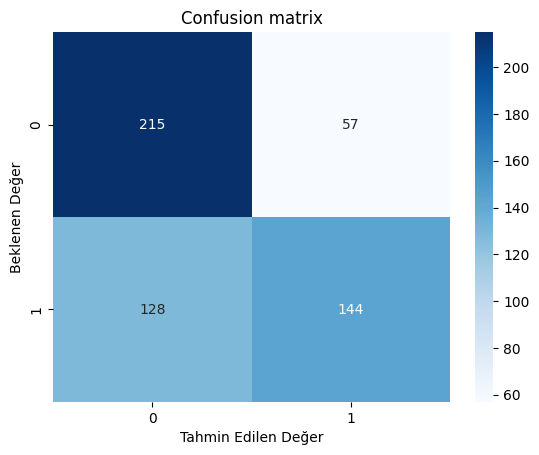

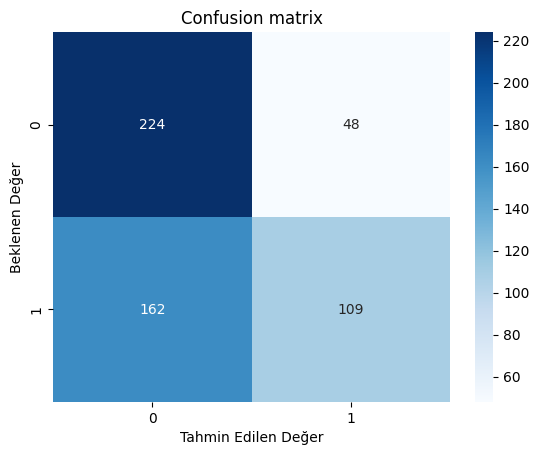

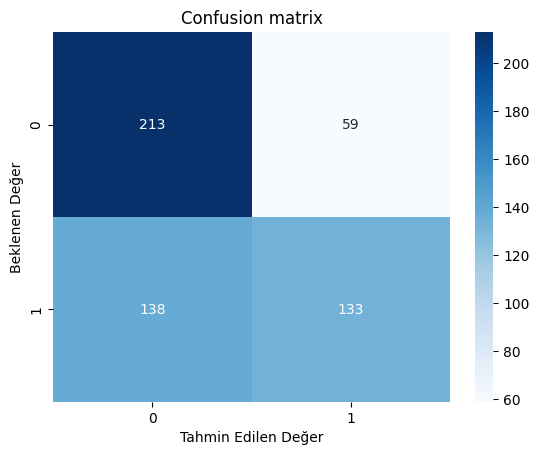

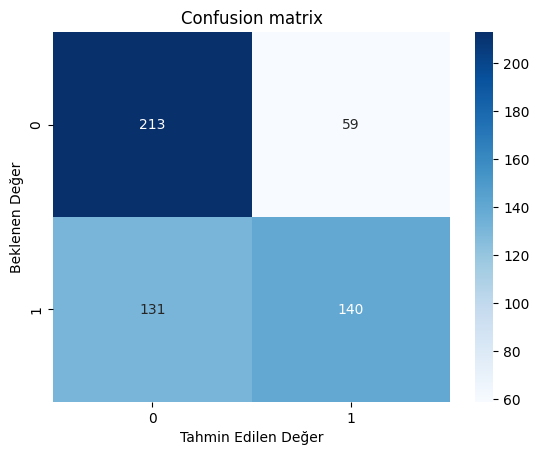

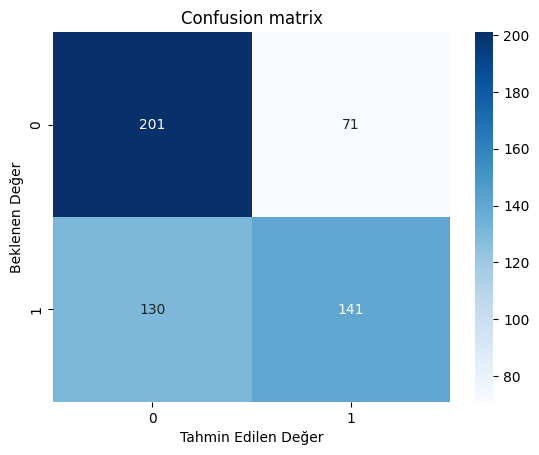

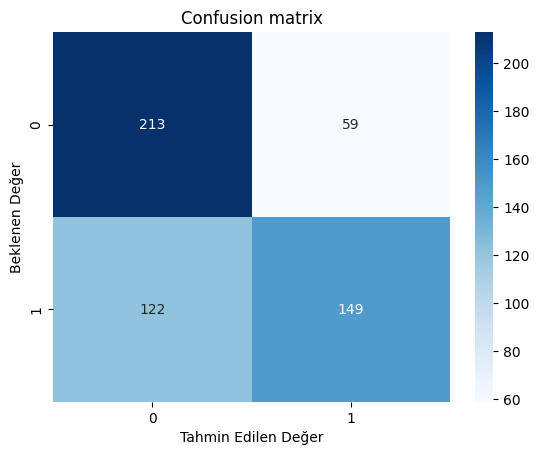

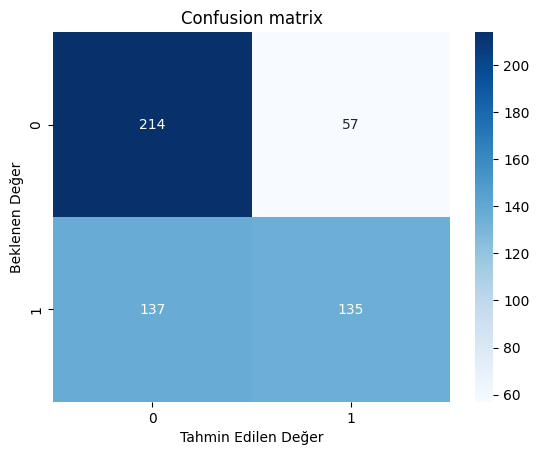

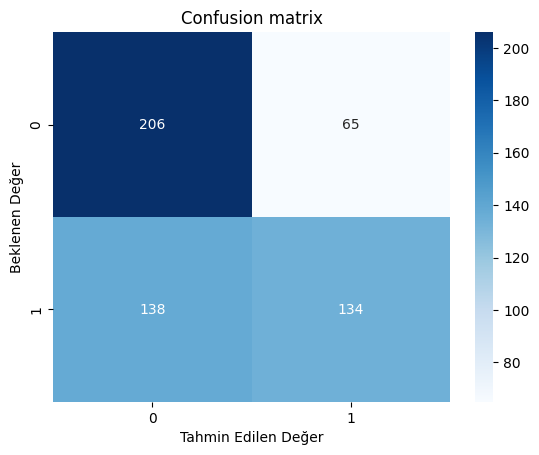

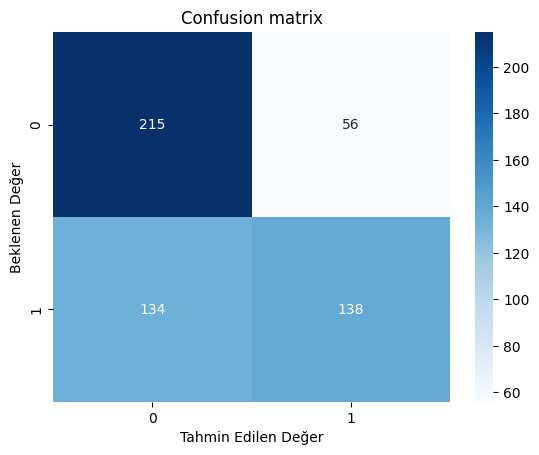

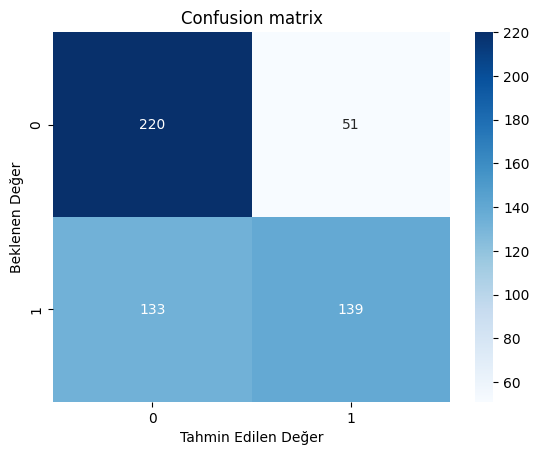

{'fbeta': [0.6088794926004228, 0.5093457943925234, 0.5745140388768899, 0.5957446808510638, 0.5838509316770186, 0.6221294363256784, 0.581896551724138, 0.5690021231422505, 0.592274678111588, 0.6017316017316017], 'precision': [0.7164179104477612, 0.6942675159235668, 0.6927083333333334, 0.7035175879396985, 0.6650943396226415, 0.7163461538461539, 0.703125, 0.6733668341708543, 0.711340206185567, 0.7315789473684211], 'recall': [0.5294117647058824, 0.4022140221402214, 0.4907749077490775, 0.5166051660516605, 0.5202952029520295, 0.5498154981549815, 0.4963235294117647, 0.49264705882352944, 0.5073529411764706, 0.5110294117647058], 'accuracy': [0.6599264705882353, 0.6132596685082873, 0.6372007366482505, 0.6500920810313076, 0.6298342541436464, 0.6666666666666666, 0.6427255985267035, 0.6261510128913443, 0.6500920810313076, 0.6611418047882136], 'y_test': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  

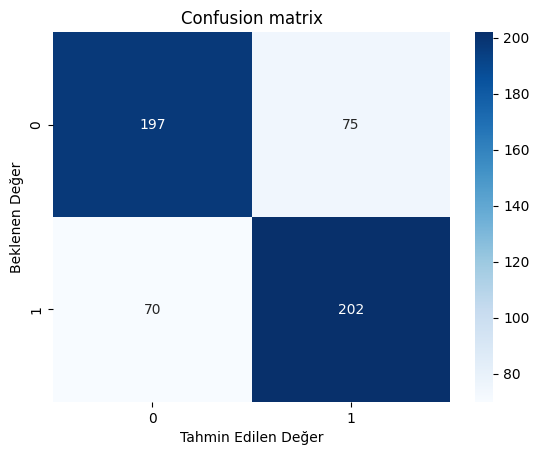

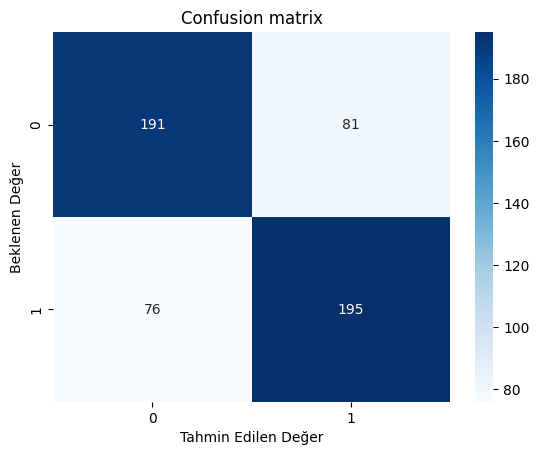

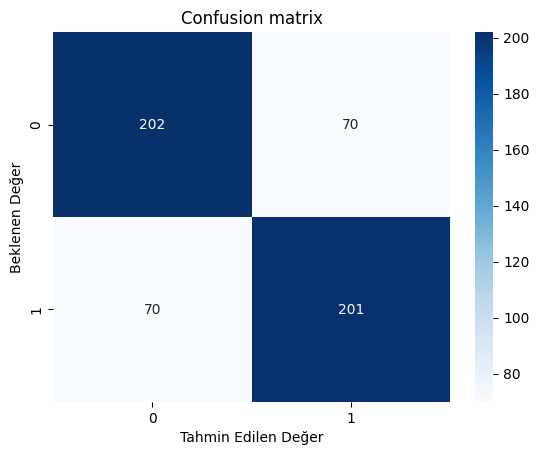

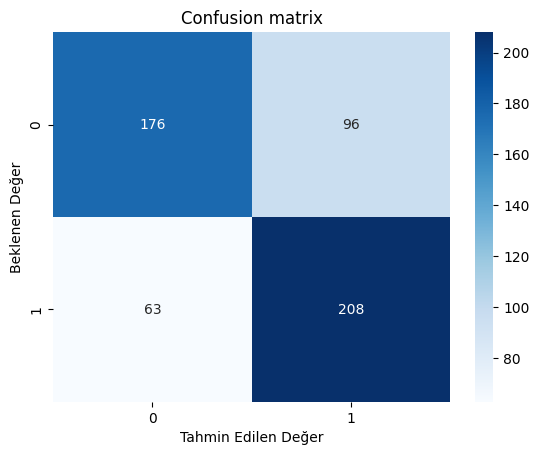

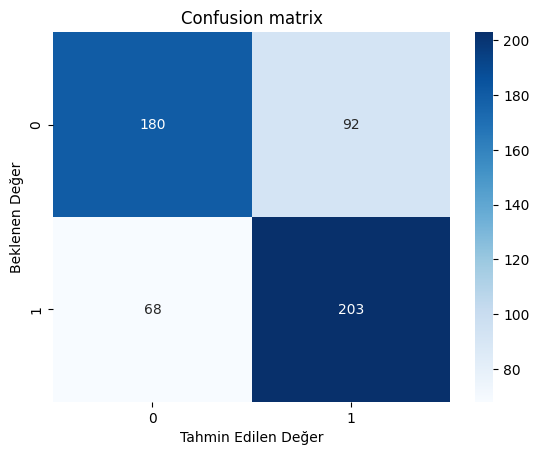

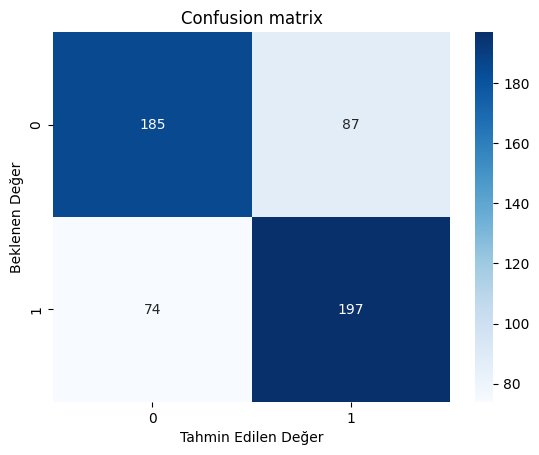

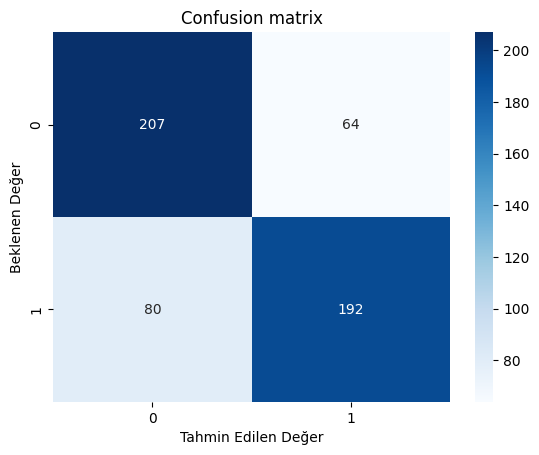

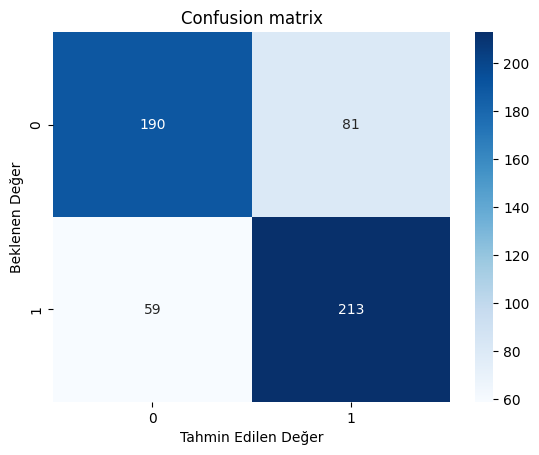

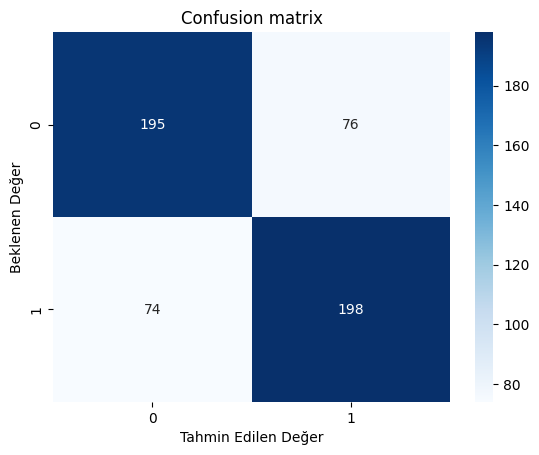

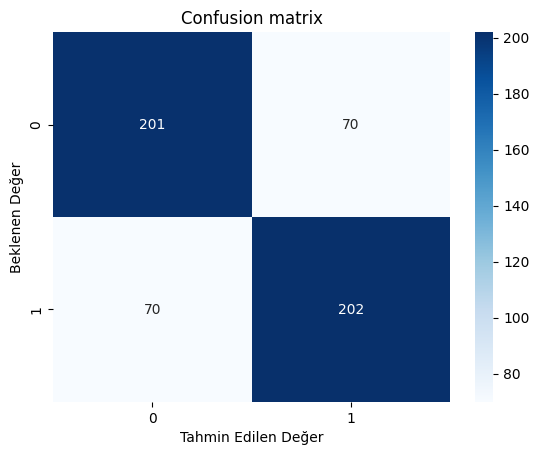

{'fbeta': [0.7358834244080146, 0.7129798903107861, 0.7416974169741697, 0.7234782608695652, 0.7173144876325088, 0.70990990990991, 0.7272727272727272, 0.7526501766784452, 0.7252747252747253, 0.7426470588235294], 'precision': [0.7292418772563177, 0.7065217391304348, 0.7416974169741697, 0.6842105263157895, 0.688135593220339, 0.6936619718309859, 0.75, 0.7244897959183674, 0.7226277372262774, 0.7426470588235294], 'recall': [0.7426470588235294, 0.7195571955719557, 0.7416974169741697, 0.7675276752767528, 0.7490774907749077, 0.7269372693726938, 0.7058823529411765, 0.7830882352941176, 0.7279411764705882, 0.7426470588235294], 'accuracy': [0.7334558823529411, 0.7108655616942909, 0.7421731123388582, 0.7071823204419889, 0.7053406998158379, 0.7034990791896869, 0.7348066298342542, 0.7421731123388582, 0.7237569060773481, 0.7421731123388582], 'y_test': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       

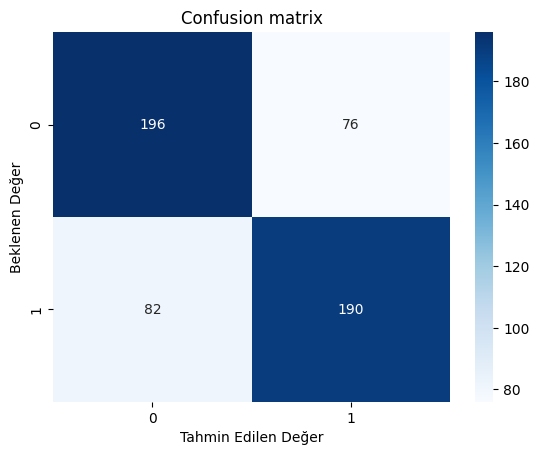

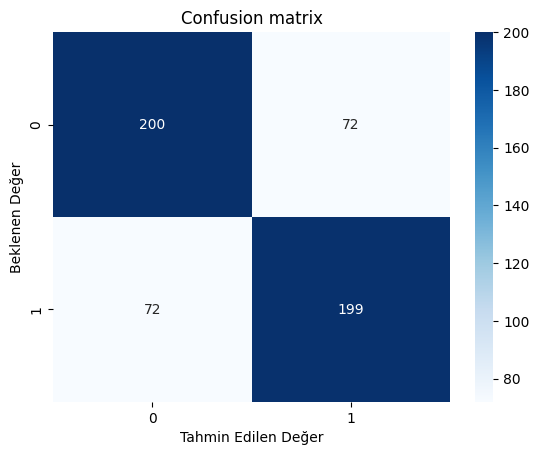

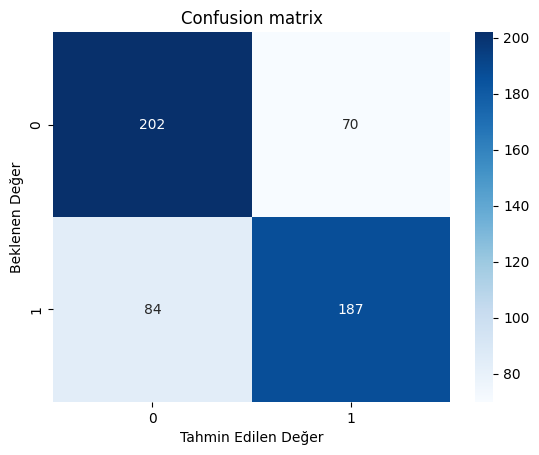

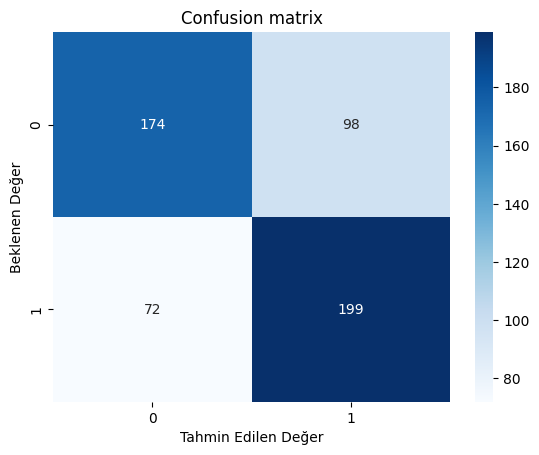

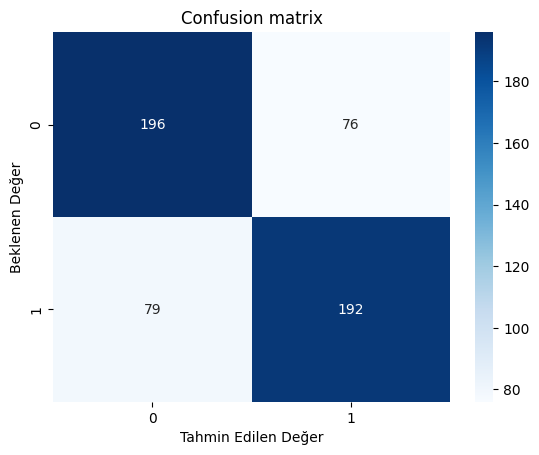

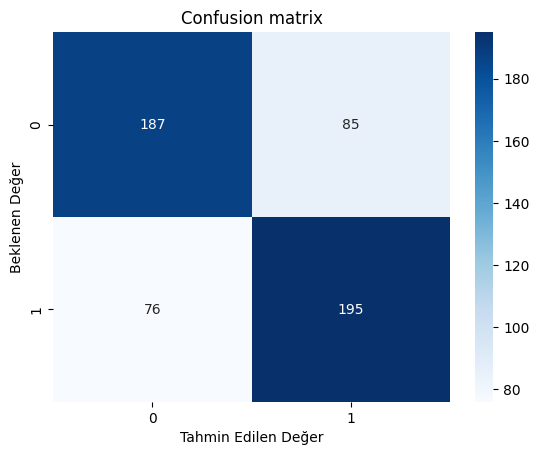

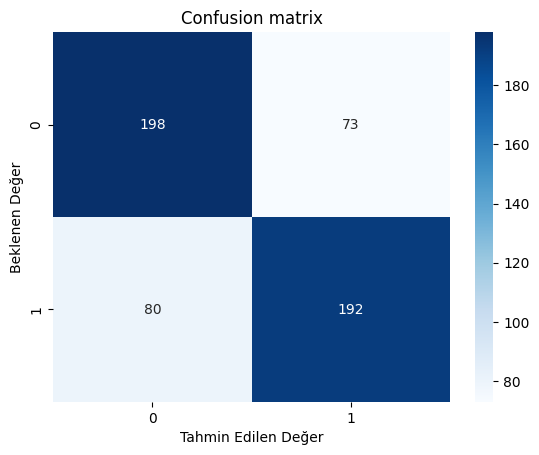

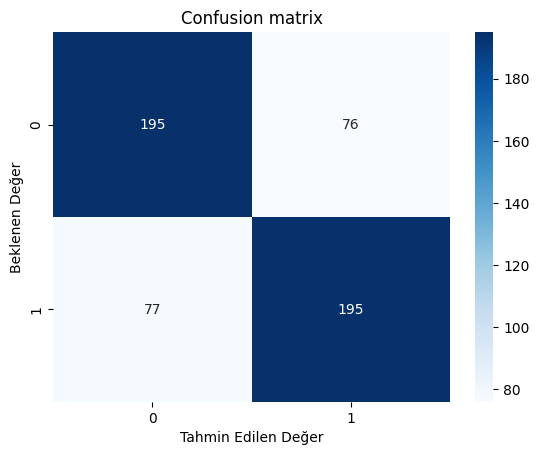

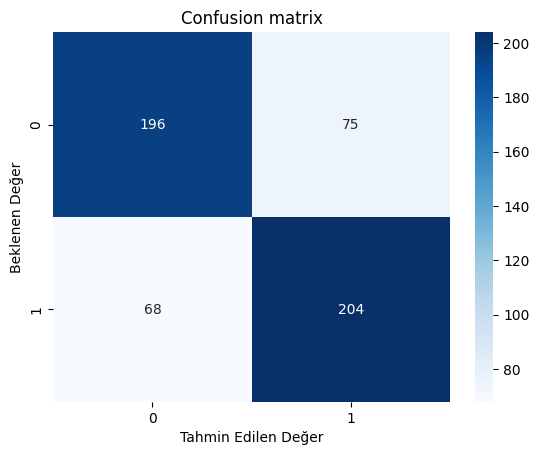

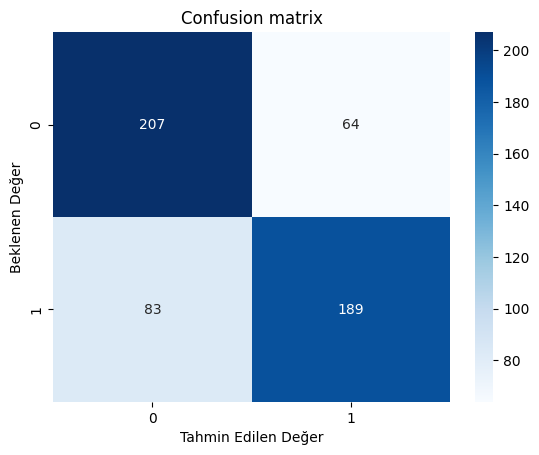

{'fbeta': [0.7063197026022305, 0.7343173431734318, 0.7083333333333333, 0.7007042253521127, 0.7124304267161409, 0.7078039927404719, 0.7150837988826816, 0.718232044198895, 0.7404718693284936, 0.7199999999999999], 'precision': [0.7142857142857143, 0.7343173431734318, 0.7276264591439688, 0.67003367003367, 0.7164179104477612, 0.6964285714285714, 0.7245283018867924, 0.7195571955719557, 0.7311827956989247, 0.7470355731225297], 'recall': [0.6985294117647058, 0.7343173431734318, 0.6900369003690037, 0.7343173431734318, 0.7084870848708487, 0.7195571955719557, 0.7058823529411765, 0.7169117647058824, 0.75, 0.6948529411764706], 'accuracy': [0.7095588235294118, 0.7348066298342542, 0.716390423572744, 0.6869244935543278, 0.714548802946593, 0.7034990791896869, 0.7182320441988951, 0.7182320441988951, 0.7366482504604052, 0.7292817679558011], 'y_test': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0,

chi2
GaussianNB


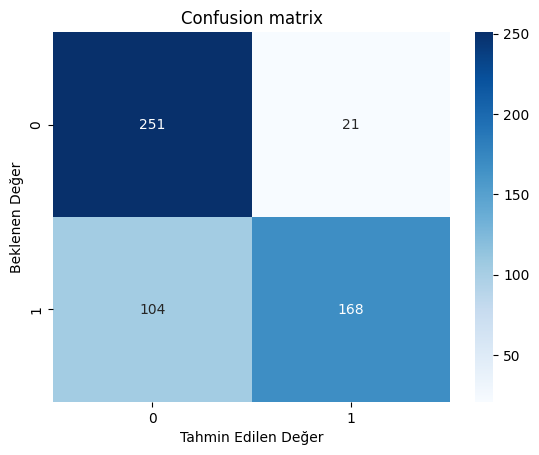

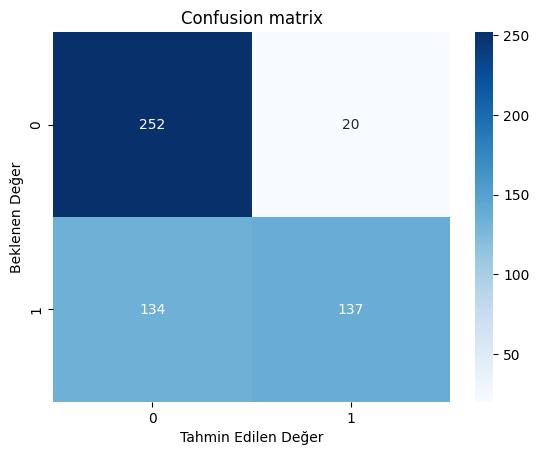

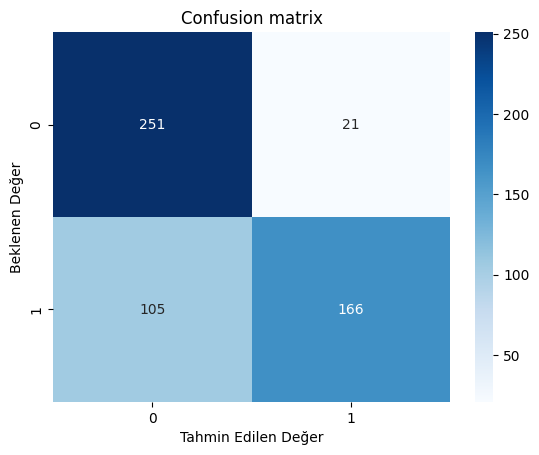

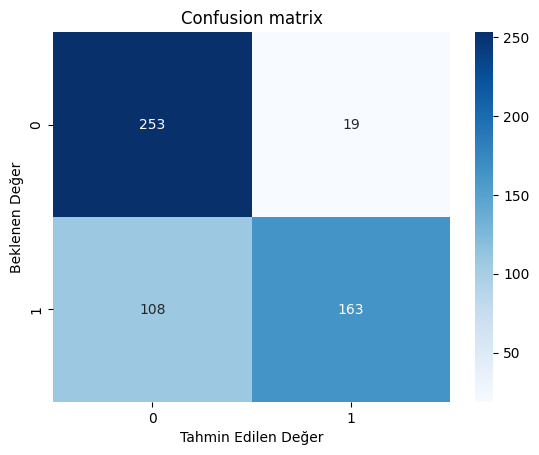

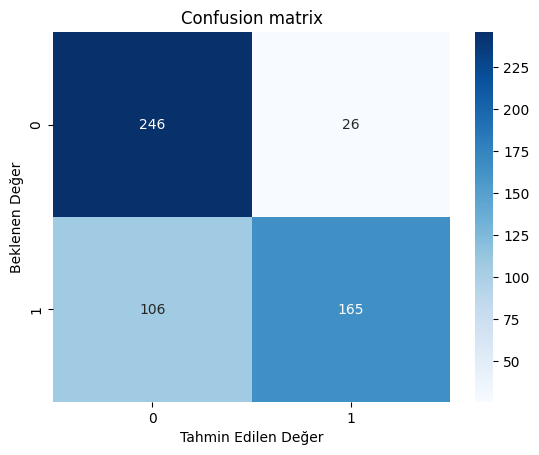

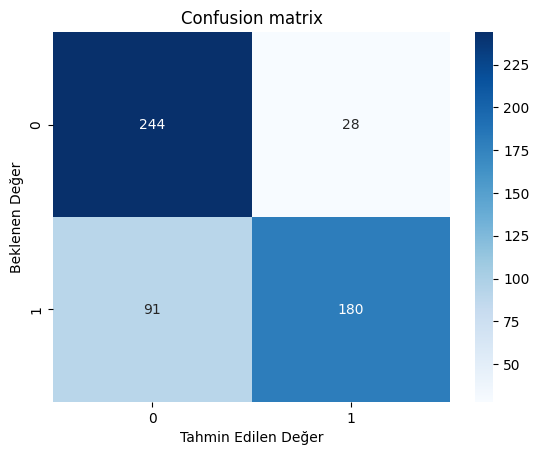

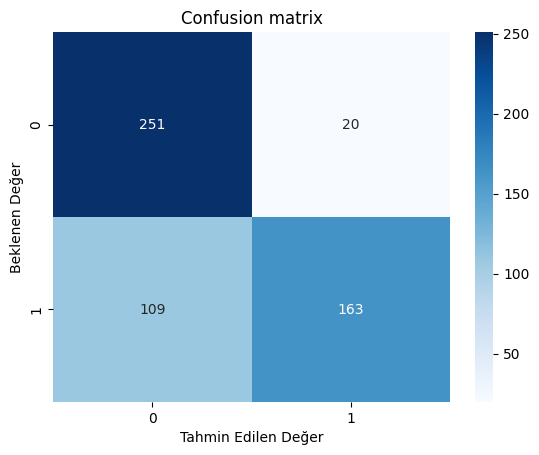

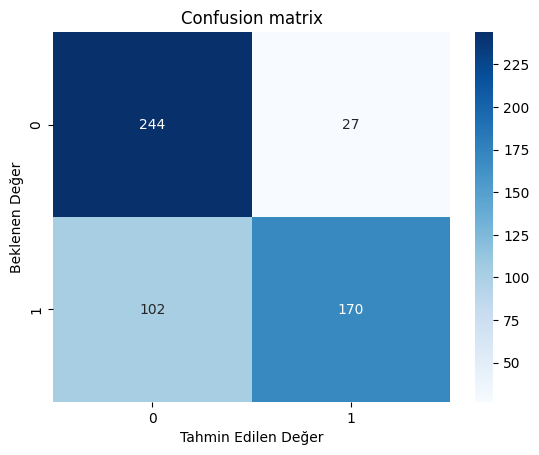

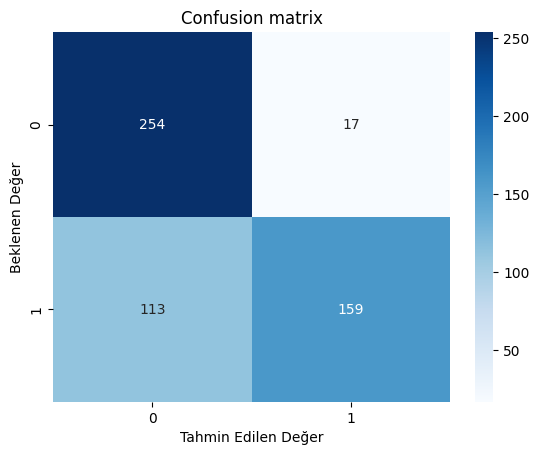

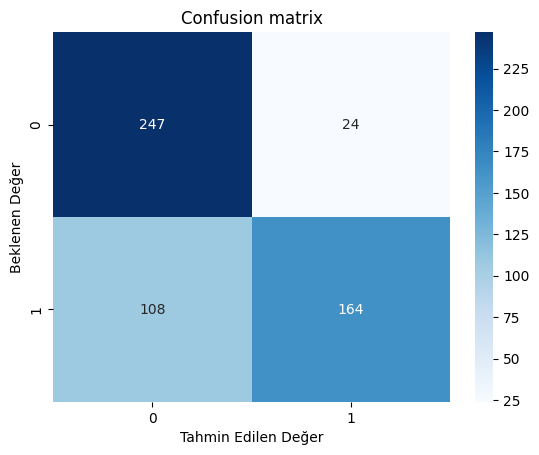

{'fbeta': [0.7288503253796096, 0.6401869158878506, 0.7248908296943232, 0.7196467991169977, 0.7142857142857142, 0.7515657620041755, 0.7164835164835165, 0.7249466950959488, 0.7098214285714287, 0.7130434782608696], 'precision': [0.8888888888888888, 0.8726114649681529, 0.8877005347593583, 0.8956043956043956, 0.8638743455497382, 0.8653846153846154, 0.8907103825136612, 0.8629441624365483, 0.9034090909090909, 0.8723404255319149], 'recall': [0.6176470588235294, 0.5055350553505535, 0.6125461254612546, 0.6014760147601476, 0.6088560885608856, 0.6642066420664207, 0.5992647058823529, 0.625, 0.5845588235294118, 0.6029411764705882], 'accuracy': [0.7702205882352942, 0.716390423572744, 0.7679558011049724, 0.7661141804788214, 0.7569060773480663, 0.7808471454880295, 0.7624309392265194, 0.7624309392265194, 0.7605893186003683, 0.7569060773480663], 'y_test': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    

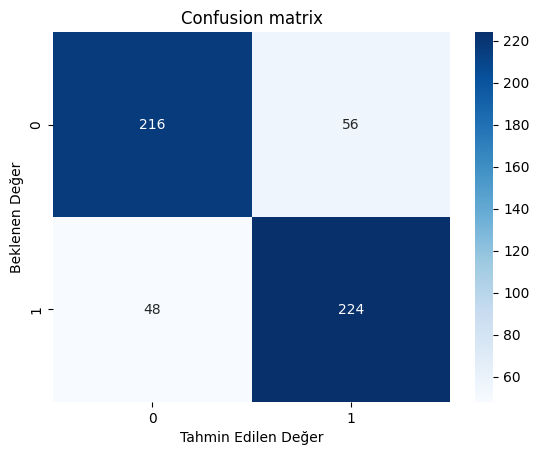

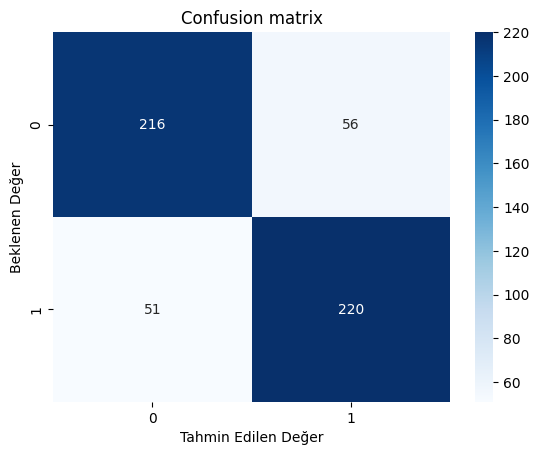

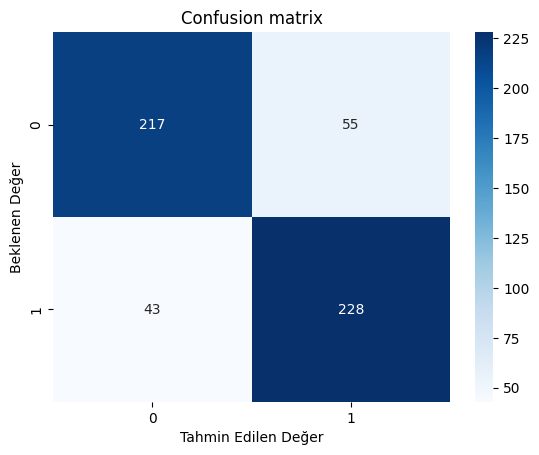

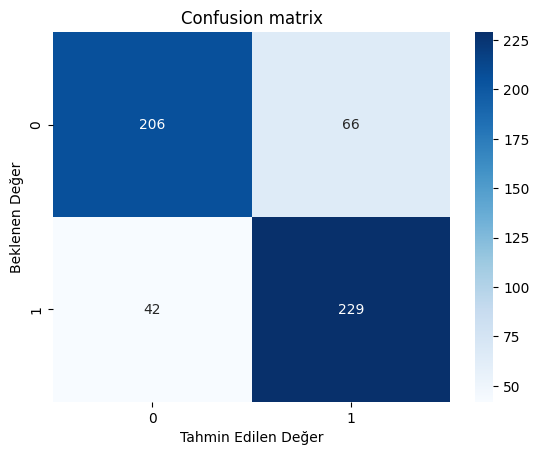

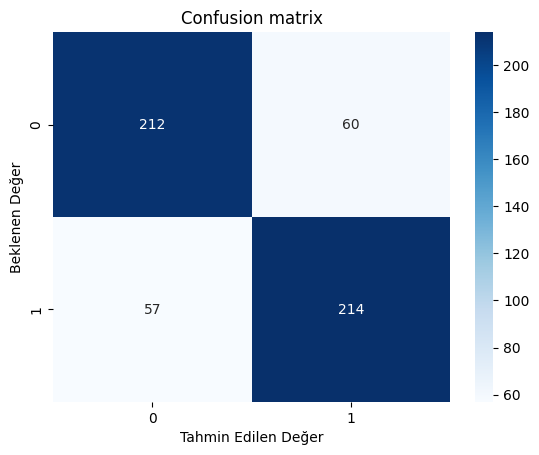

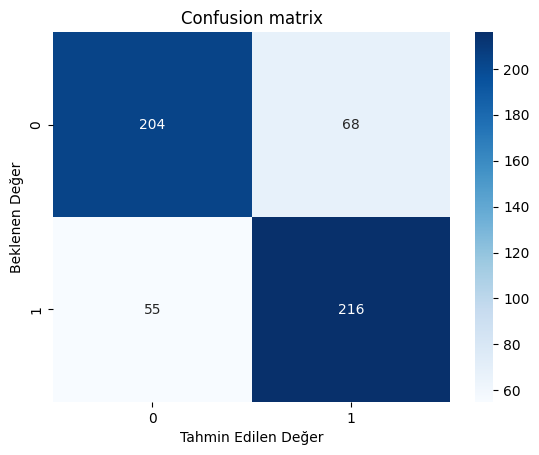

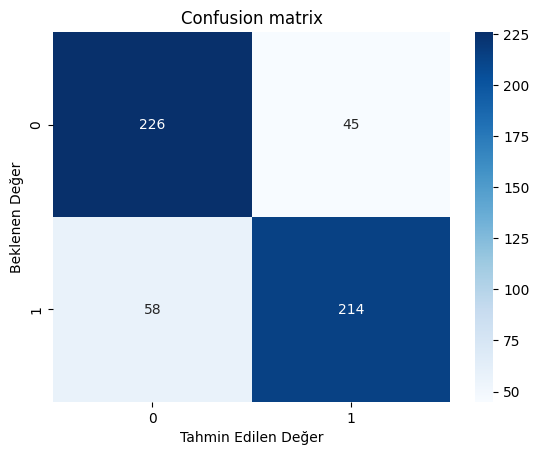

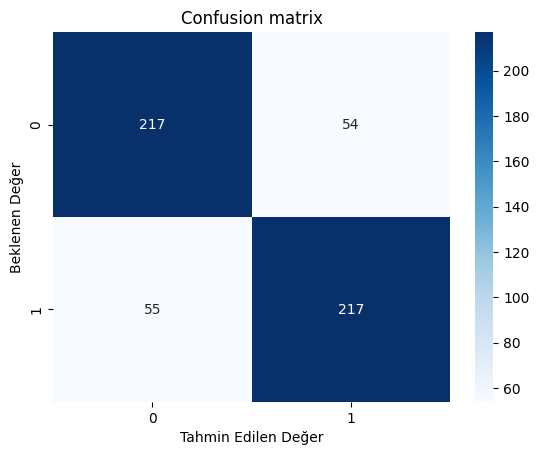

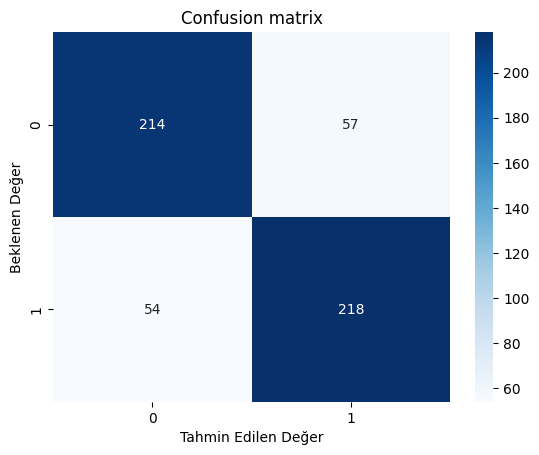

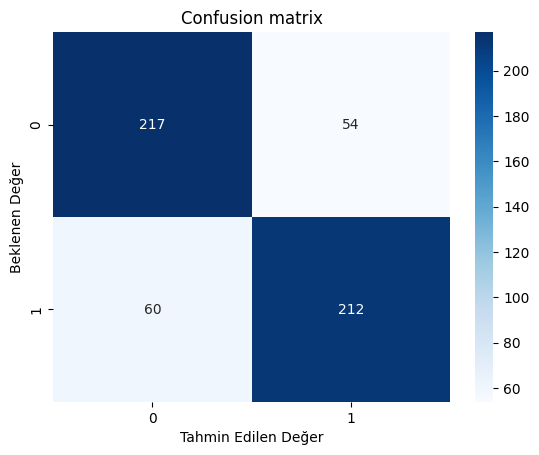

{'fbeta': [0.8115942028985507, 0.8043875685557587, 0.8231046931407942, 0.8091872791519434, 0.7853211009174311, 0.7783783783783784, 0.8060263653483993, 0.7992633517495396, 0.7970749542961609, 0.788104089219331], 'precision': [0.8, 0.7971014492753623, 0.8056537102473498, 0.7762711864406779, 0.781021897810219, 0.7605633802816901, 0.8262548262548263, 0.8007380073800738, 0.7927272727272727, 0.7969924812030075], 'recall': [0.8235294117647058, 0.8118081180811808, 0.8413284132841329, 0.8450184501845018, 0.7896678966789668, 0.7970479704797048, 0.7867647058823529, 0.7977941176470589, 0.8014705882352942, 0.7794117647058824], 'accuracy': [0.8088235294117647, 0.8029465930018416, 0.8195211786372008, 0.8011049723756906, 0.7845303867403315, 0.7734806629834254, 0.8103130755064457, 0.7992633517495396, 0.7955801104972375, 0.7900552486187845], 'y_test': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       

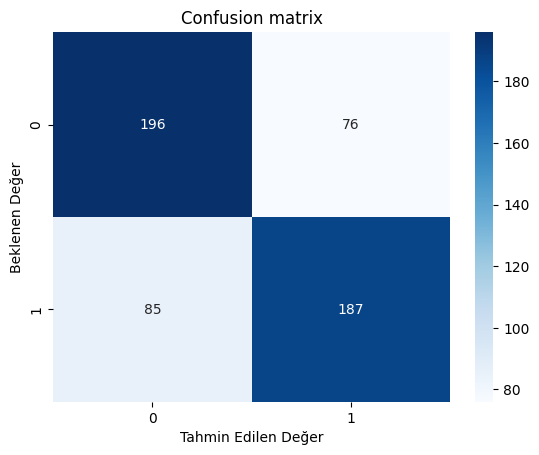

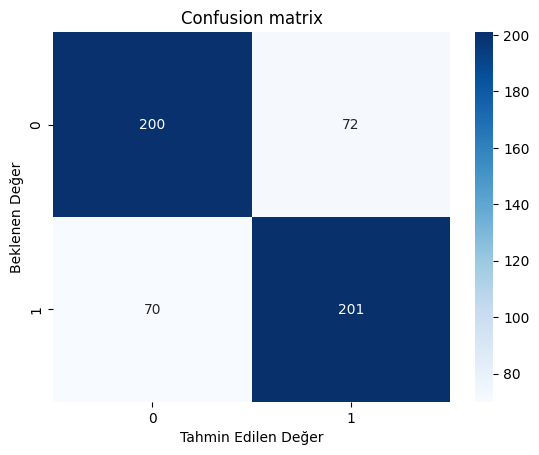

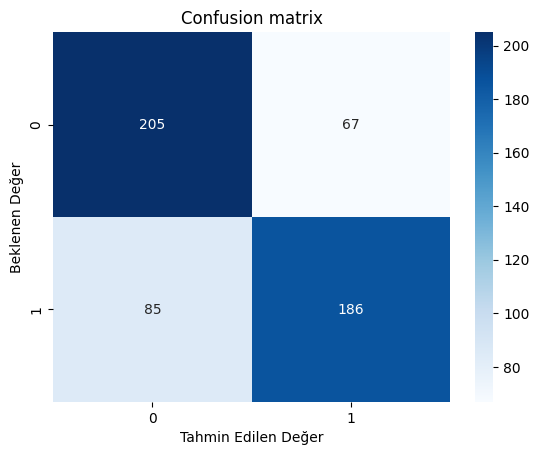

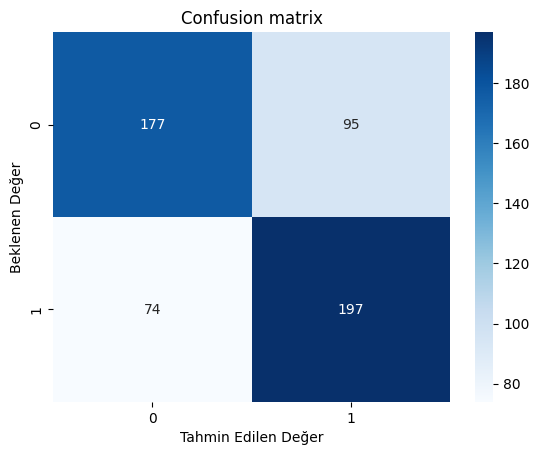

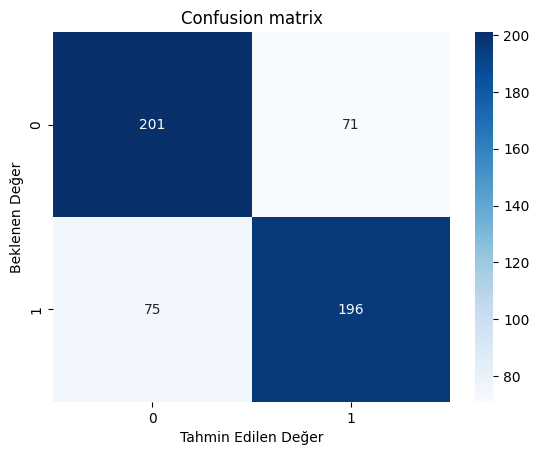

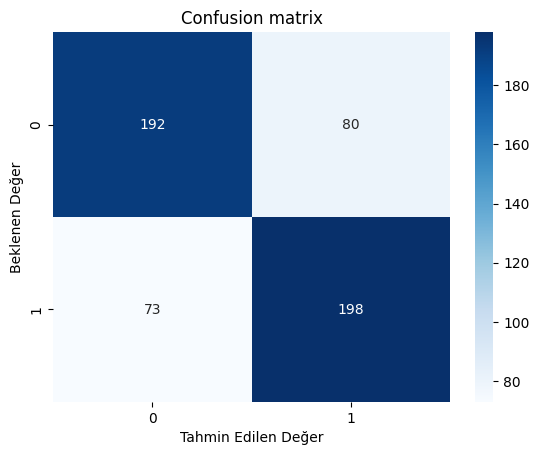

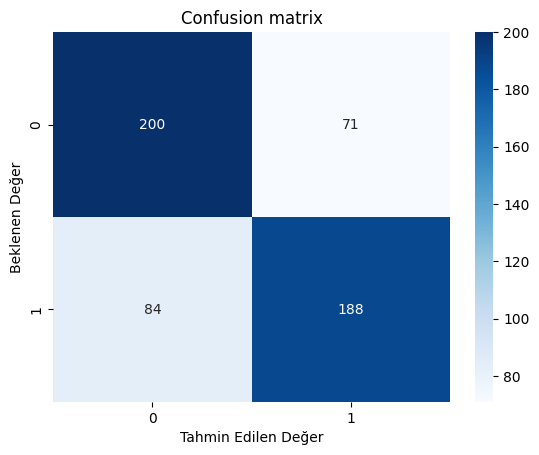

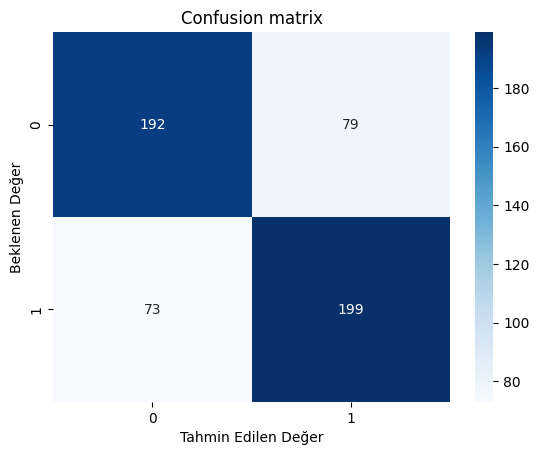

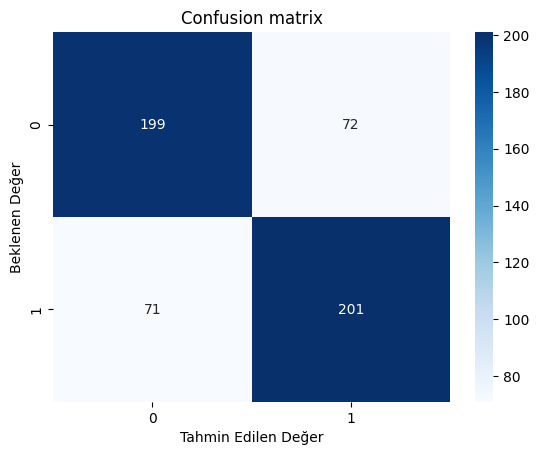

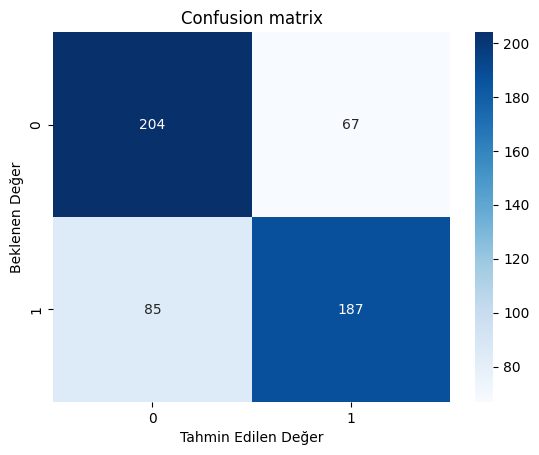

{'fbeta': [0.6990654205607477, 0.738970588235294, 0.7099236641221375, 0.6998223801065719, 0.7286245353159851, 0.7213114754098361, 0.7080979284369114, 0.7236363636363637, 0.7376146788990826, 0.7110266159695818], 'precision': [0.7110266159695817, 0.7362637362637363, 0.7351778656126482, 0.6746575342465754, 0.7340823970037453, 0.7122302158273381, 0.7258687258687259, 0.7158273381294964, 0.7362637362637363, 0.7362204724409449], 'recall': [0.6875, 0.7416974169741697, 0.6863468634686347, 0.7269372693726938, 0.7232472324723247, 0.7306273062730627, 0.6911764705882353, 0.7316176470588235, 0.7389705882352942, 0.6875], 'accuracy': [0.7040441176470589, 0.7384898710865562, 0.7200736648250461, 0.6887661141804788, 0.7311233885819521, 0.7182320441988951, 0.714548802946593, 0.7200736648250461, 0.7366482504604052, 0.7200736648250461], 'y_test': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 

or
GaussianNB


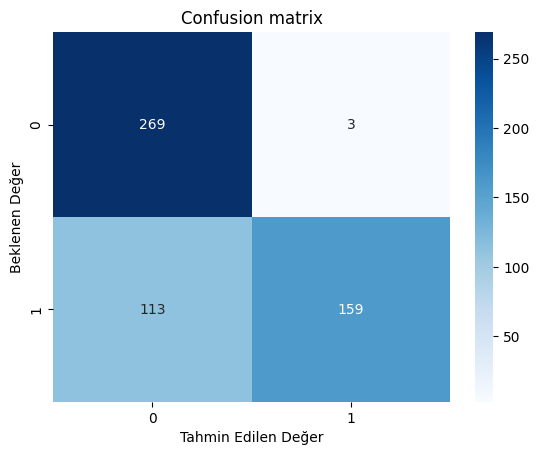

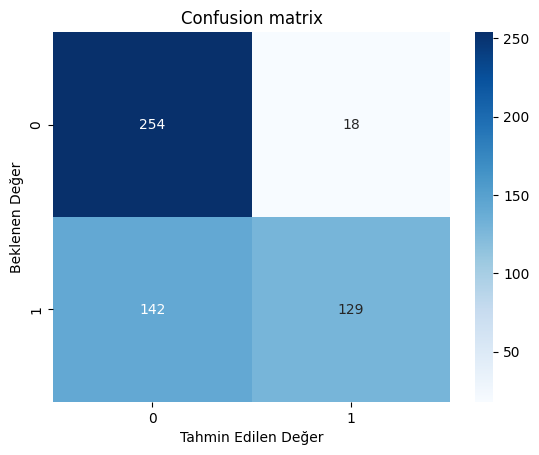

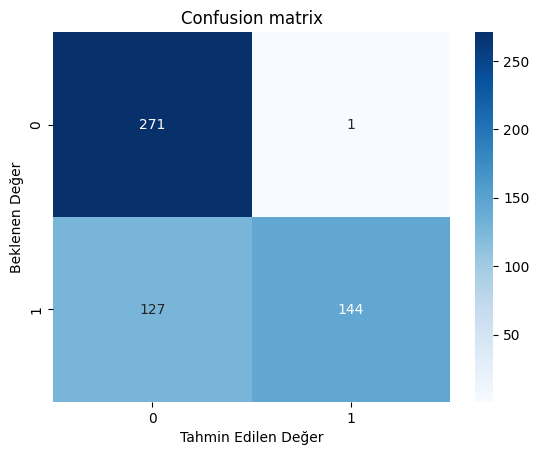

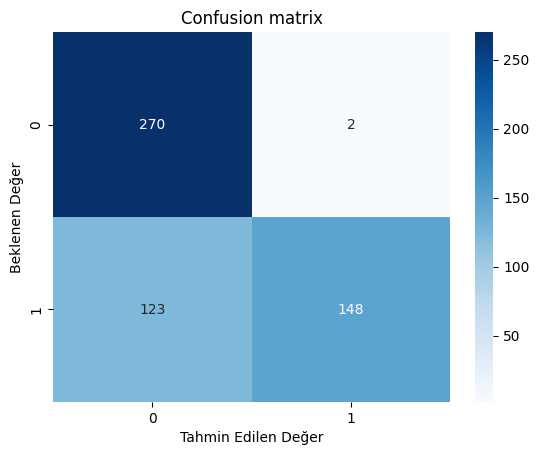

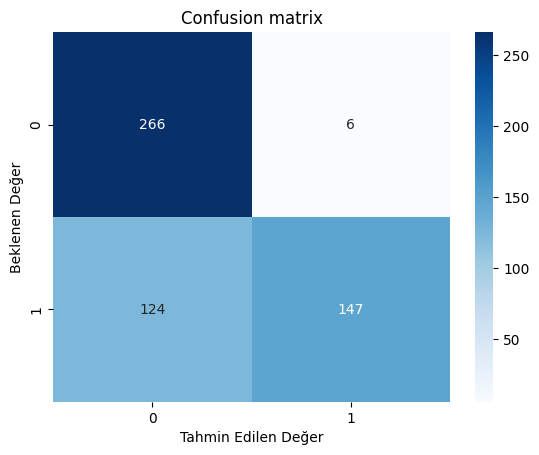

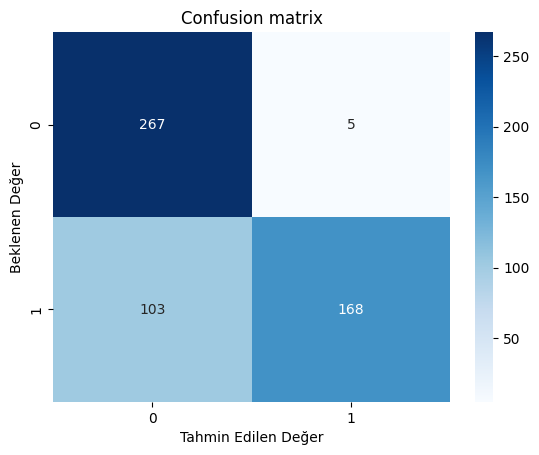

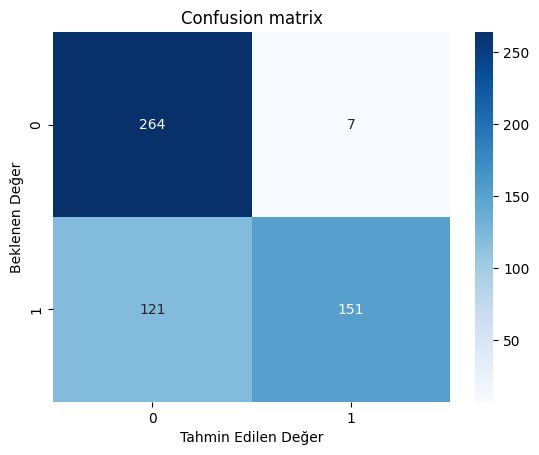

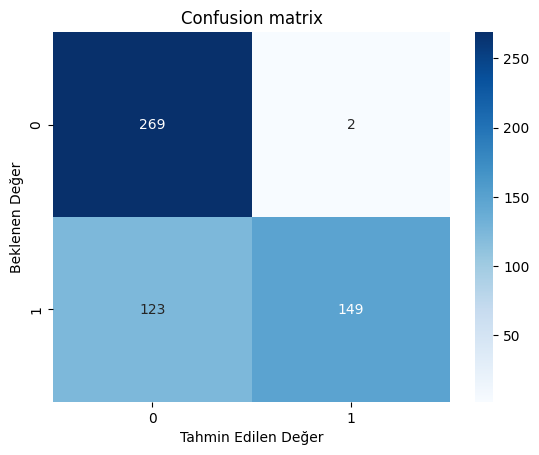

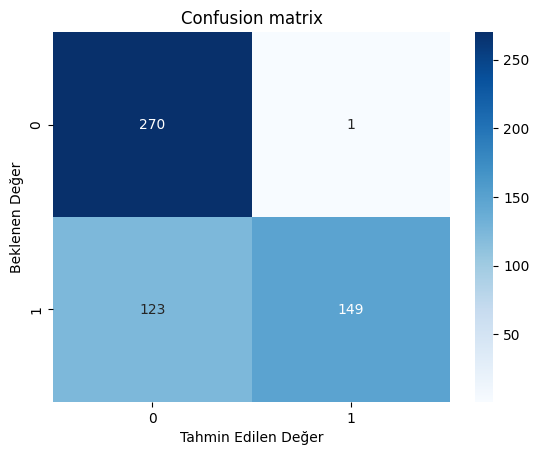

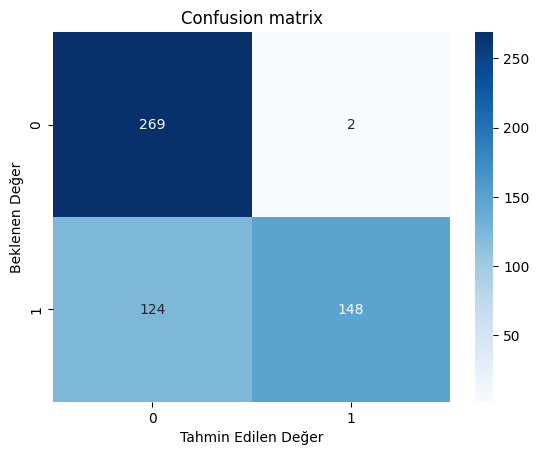

{'fbeta': [0.7327188940092166, 0.6172248803827752, 0.6923076923076923, 0.7030878859857482, 0.6933962264150944, 0.7567567567567568, 0.7023255813953488, 0.7044917257683216, 0.7061611374407584, 0.7014218009478673], 'precision': [0.9814814814814815, 0.8775510204081632, 0.993103448275862, 0.9866666666666667, 0.9607843137254902, 0.9710982658959537, 0.9556962025316456, 0.9867549668874173, 0.9933333333333333, 0.9866666666666667], 'recall': [0.5845588235294118, 0.47601476014760147, 0.5313653136531366, 0.5461254612546126, 0.5424354243542435, 0.6199261992619927, 0.5551470588235294, 0.5477941176470589, 0.5477941176470589, 0.5441176470588235], 'accuracy': [0.7867647058823529, 0.7053406998158379, 0.7642725598526704, 0.7697974217311234, 0.7605893186003683, 0.8011049723756906, 0.7642725598526704, 0.7697974217311234, 0.7716390423572744, 0.7679558011049724], 'y_test': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

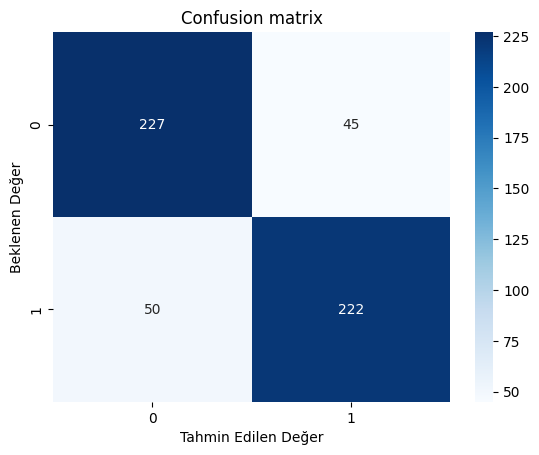

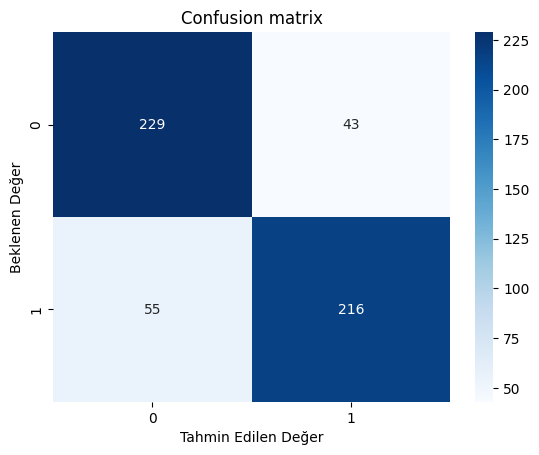

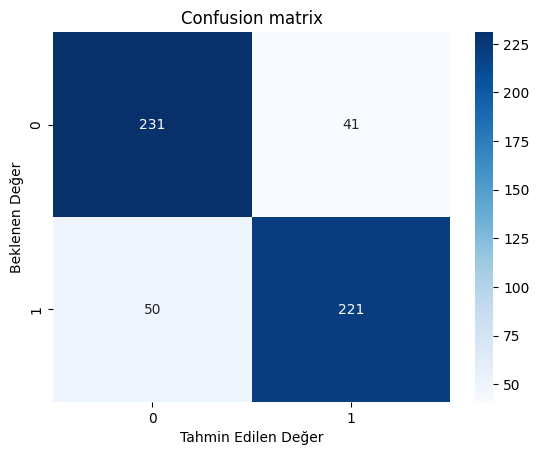

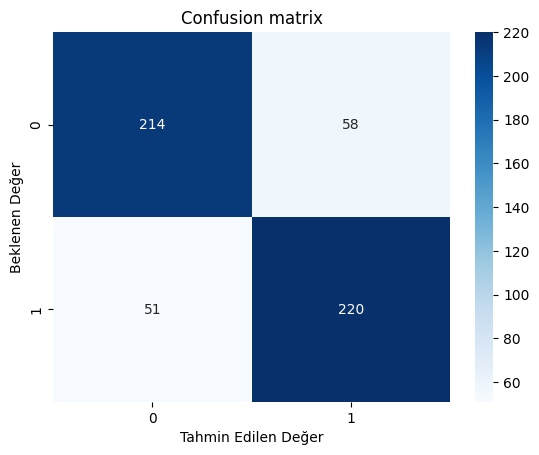

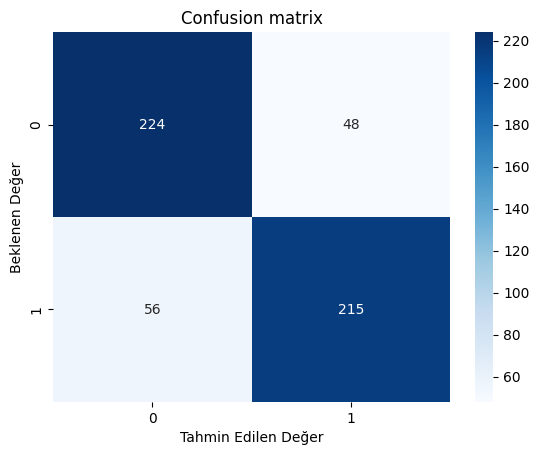

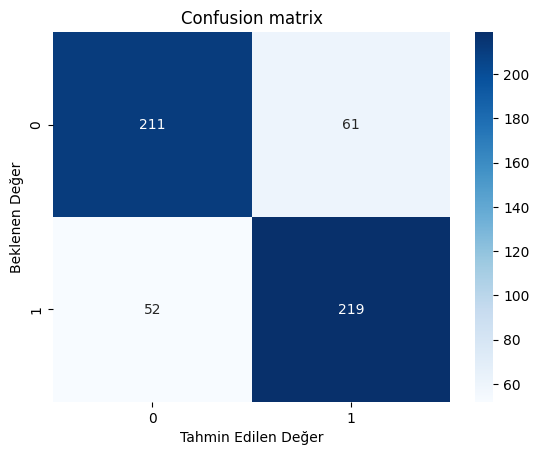

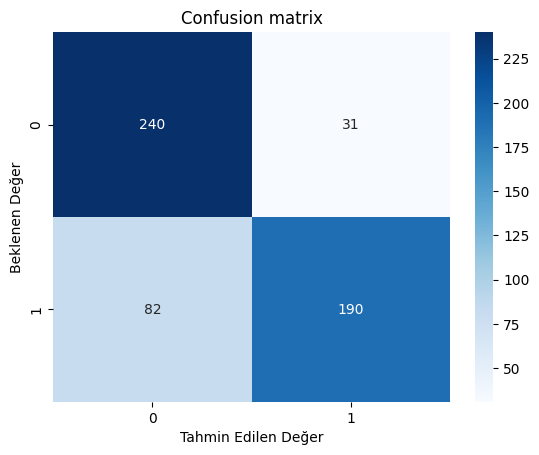

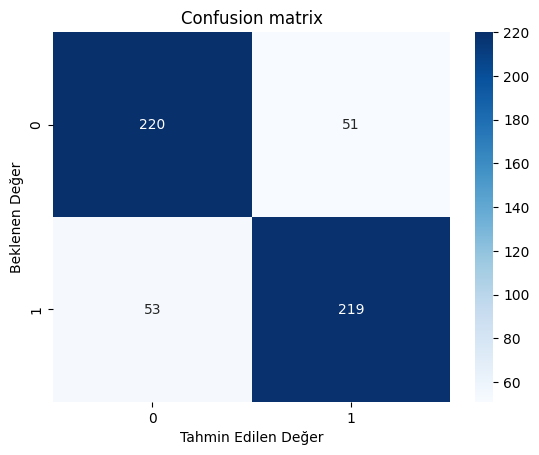

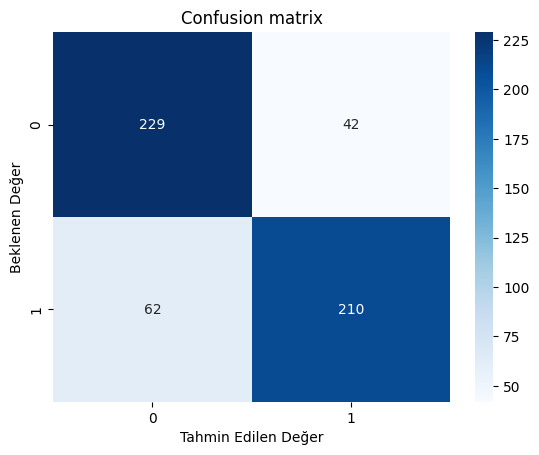

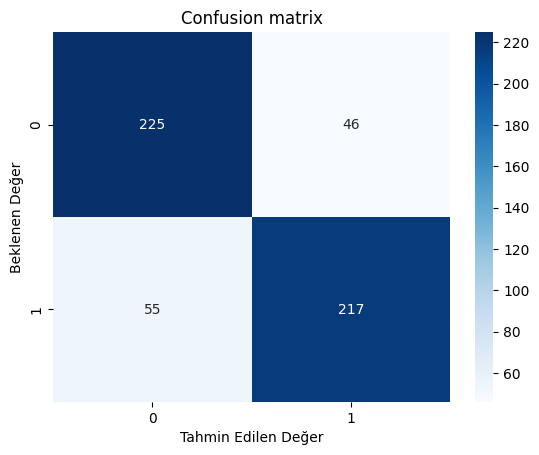

{'fbeta': [0.8237476808905381, 0.8150943396226416, 0.8292682926829269, 0.8014571948998178, 0.8052434456928839, 0.7949183303085299, 0.7707910750507099, 0.8081180811808119, 0.8015267175572519, 0.811214953271028], 'precision': [0.8314606741573034, 0.833976833976834, 0.8435114503816794, 0.7913669064748201, 0.8174904942965779, 0.7821428571428571, 0.8597285067873304, 0.8111111111111111, 0.8333333333333334, 0.8250950570342205], 'recall': [0.8161764705882353, 0.7970479704797048, 0.8154981549815498, 0.8118081180811808, 0.7933579335793358, 0.8081180811808119, 0.6985294117647058, 0.8051470588235294, 0.7720588235294118, 0.7977941176470589], 'accuracy': [0.8253676470588235, 0.8195211786372008, 0.8324125230202578, 0.7992633517495396, 0.8084714548802947, 0.7918968692449355, 0.7918968692449355, 0.8084714548802947, 0.8084714548802947, 0.8139963167587477], 'y_test': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

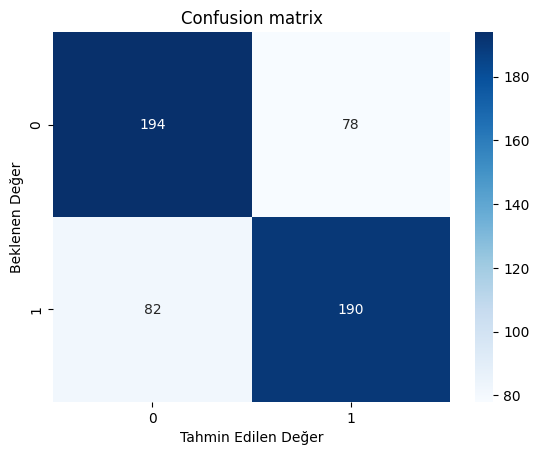

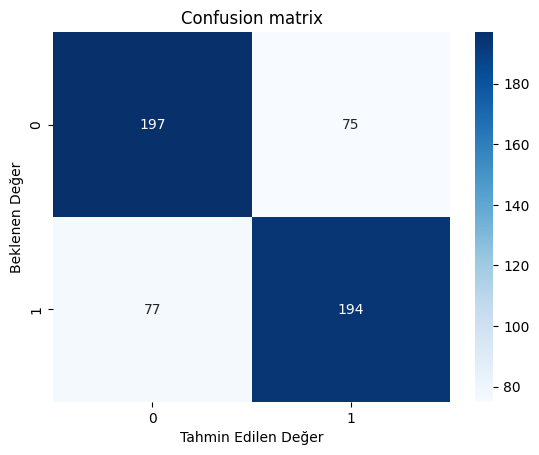

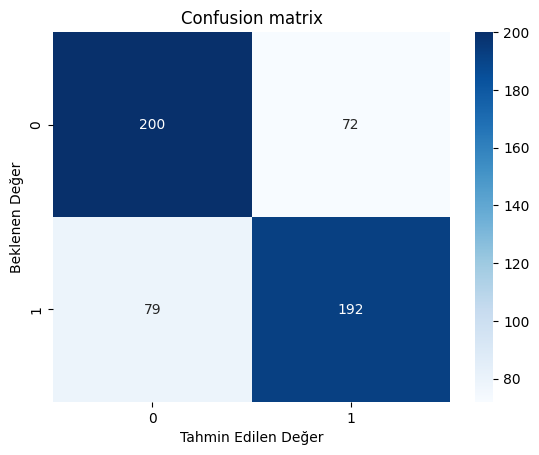

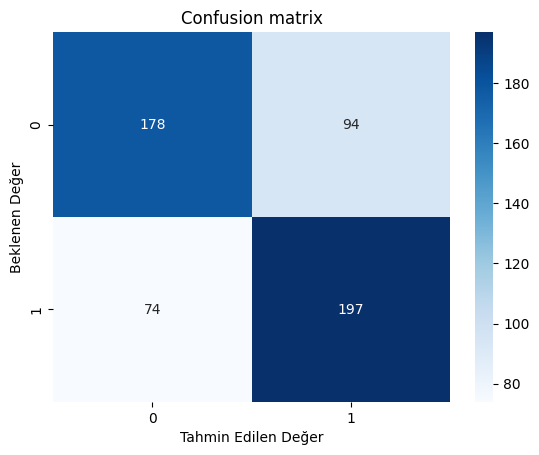

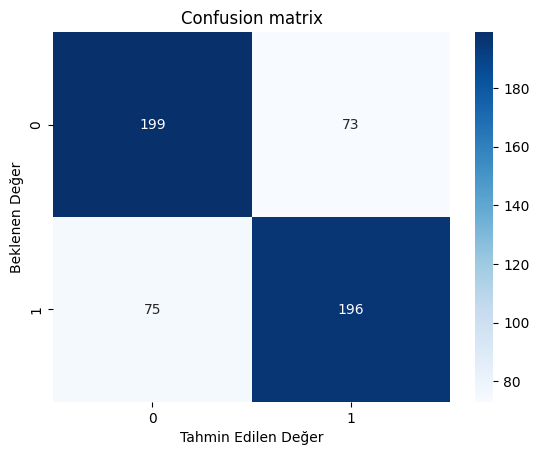

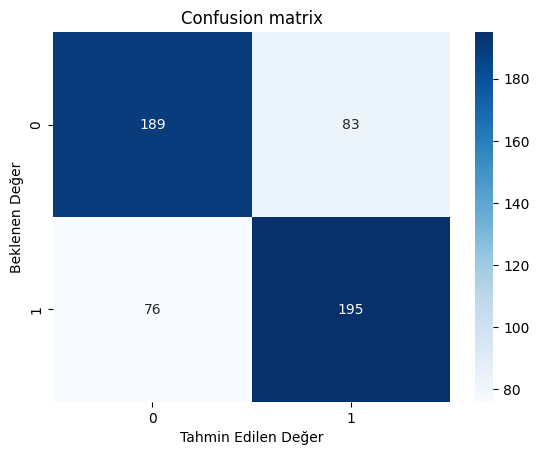

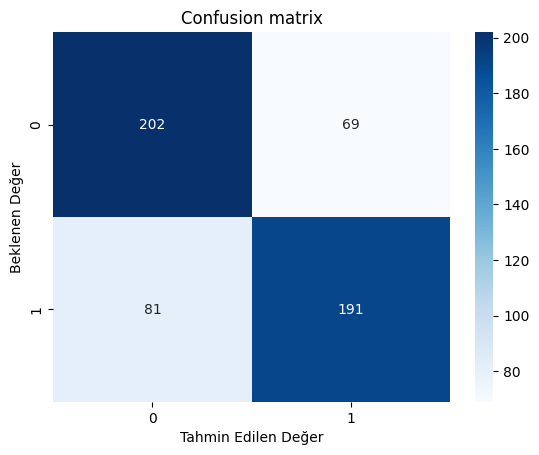

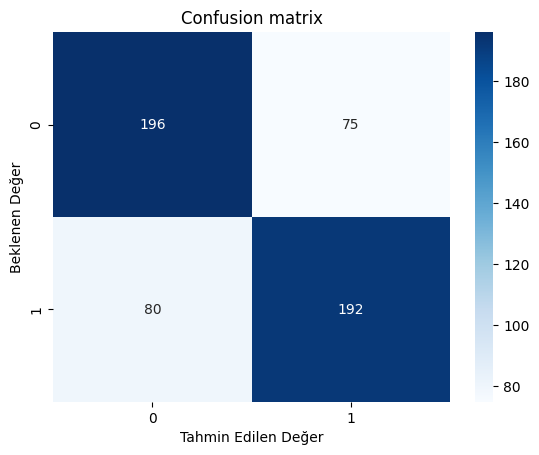

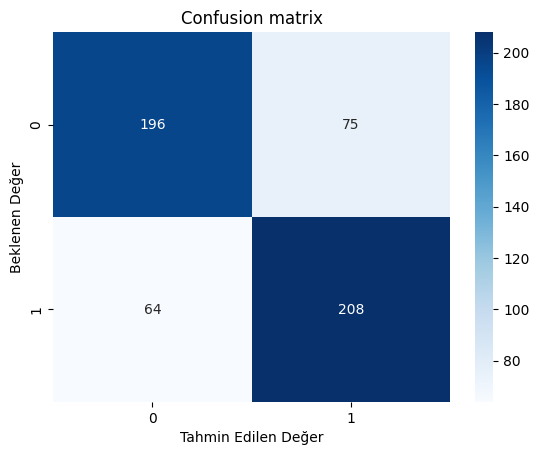

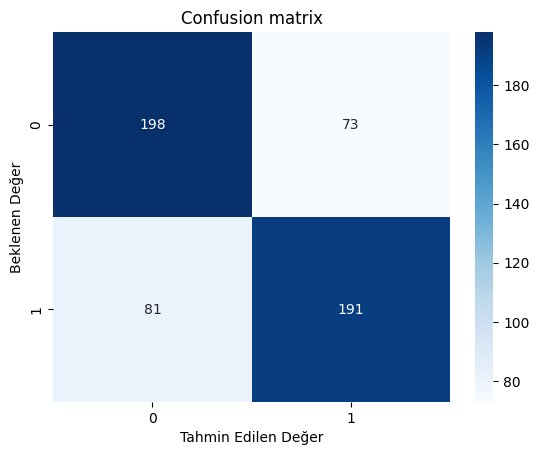

{'fbeta': [0.7037037037037037, 0.7185185185185184, 0.7177570093457943, 0.7010676156583631, 0.7259259259259259, 0.7103825136612023, 0.7180451127819549, 0.712430426716141, 0.7495495495495497, 0.7126865671641791], 'precision': [0.7089552238805971, 0.7211895910780669, 0.7272727272727273, 0.6769759450171822, 0.7286245353159851, 0.7014388489208633, 0.7346153846153847, 0.7191011235955056, 0.734982332155477, 0.7234848484848485], 'recall': [0.6985294117647058, 0.7158671586715867, 0.7084870848708487, 0.7269372693726938, 0.7232472324723247, 0.7195571955719557, 0.7022058823529411, 0.7058823529411765, 0.7647058823529411, 0.7022058823529411], 'accuracy': [0.7058823529411765, 0.7200736648250461, 0.7219152854511971, 0.6906077348066298, 0.7274401473296501, 0.7071823204419889, 0.7237569060773481, 0.714548802946593, 0.7440147329650092, 0.716390423572744], 'y_test': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

ig
GaussianNB


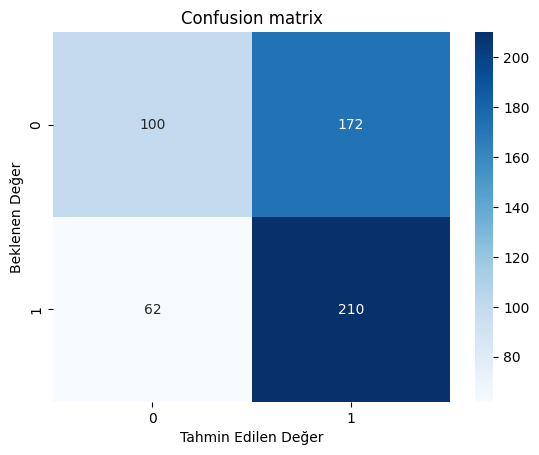

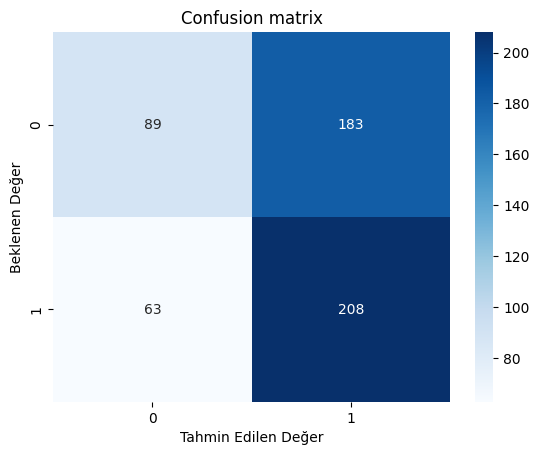

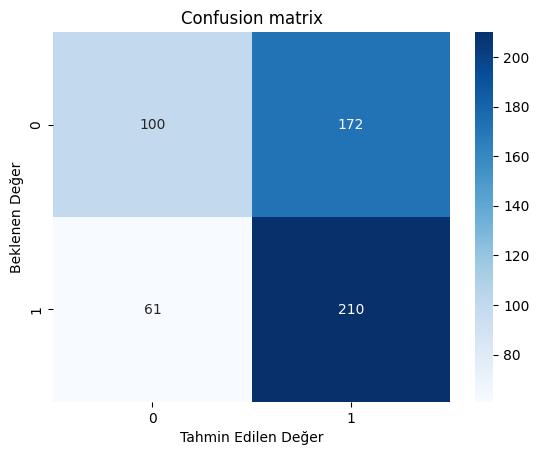

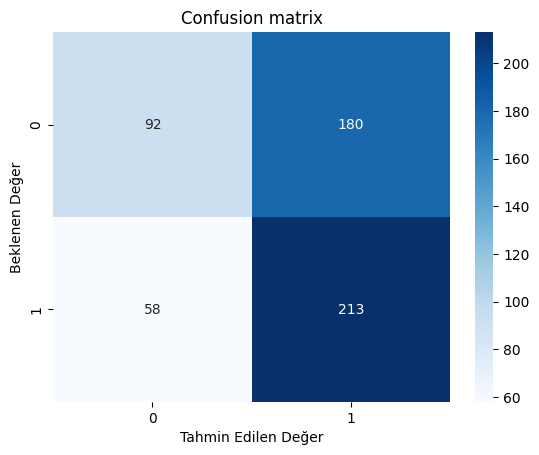

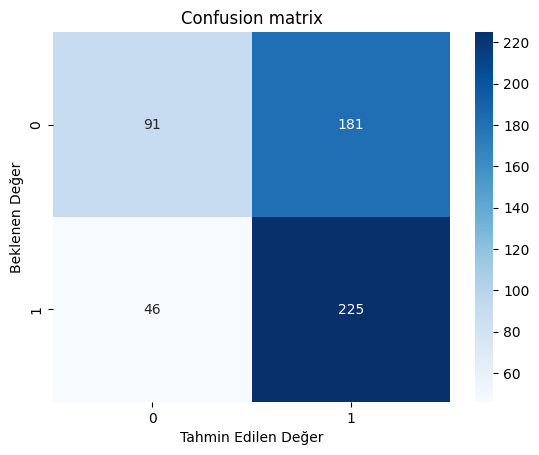

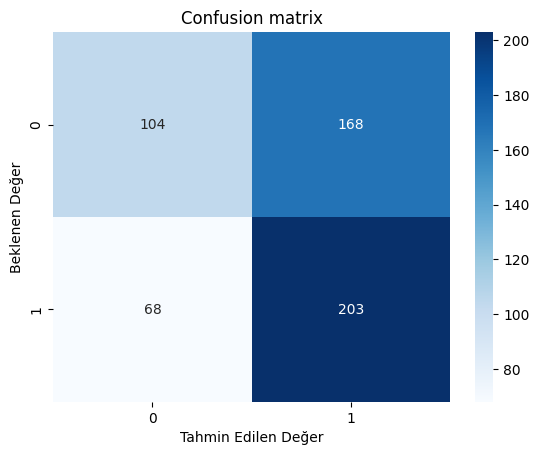

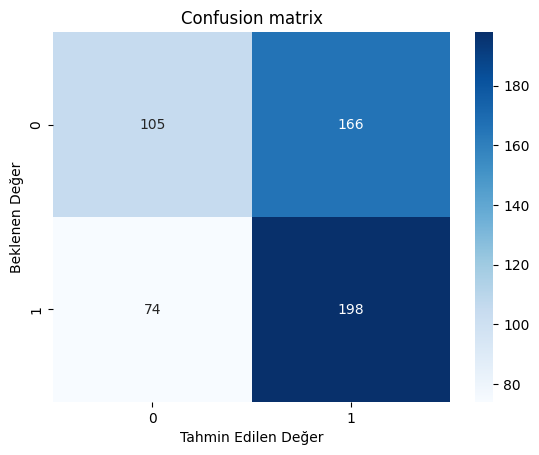

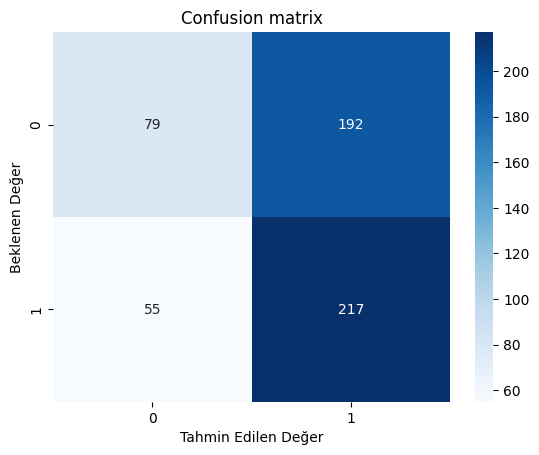

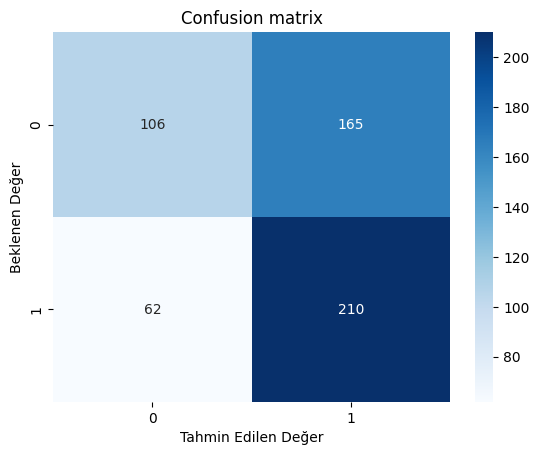

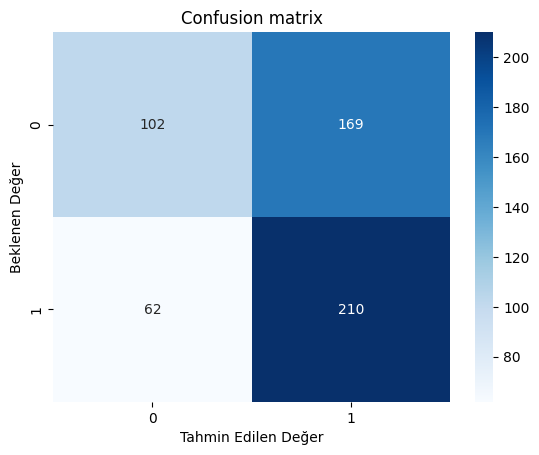

{'fbeta': [0.6422018348623854, 0.6283987915407856, 0.6431852986217458, 0.641566265060241, 0.6646971935007386, 0.632398753894081, 0.6226415094339622, 0.6372980910425844, 0.6491499227202474, 0.6451612903225807], 'precision': [0.5497382198952879, 0.5319693094629157, 0.5497382198952879, 0.5419847328244275, 0.5541871921182266, 0.5471698113207547, 0.5439560439560439, 0.530562347188264, 0.56, 0.554089709762533], 'recall': [0.7720588235294118, 0.7675276752767528, 0.7749077490774908, 0.7859778597785978, 0.8302583025830258, 0.7490774907749077, 0.7279411764705882, 0.7977941176470589, 0.7720588235294118, 0.7720588235294118], 'accuracy': [0.5698529411764706, 0.5469613259668509, 0.570902394106814, 0.5616942909760589, 0.58195211786372, 0.565377532228361, 0.5580110497237569, 0.5451197053406999, 0.58195211786372, 0.574585635359116], 'y_test': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0,

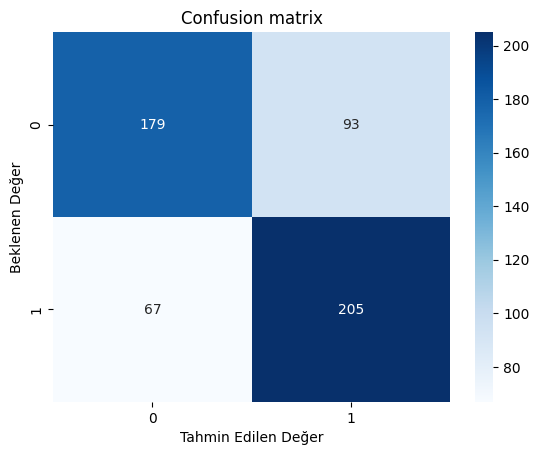

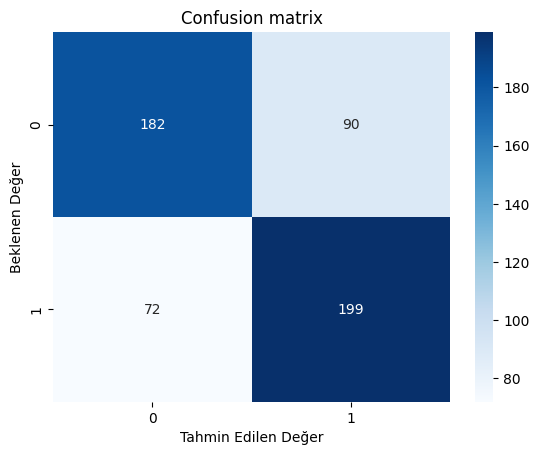

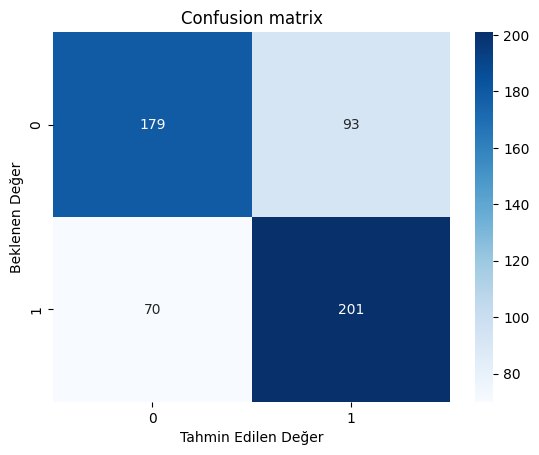

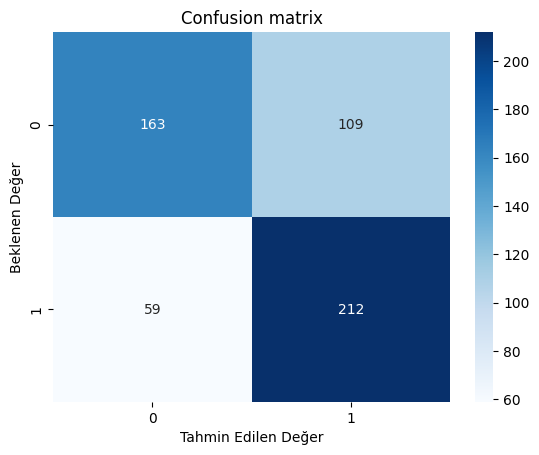

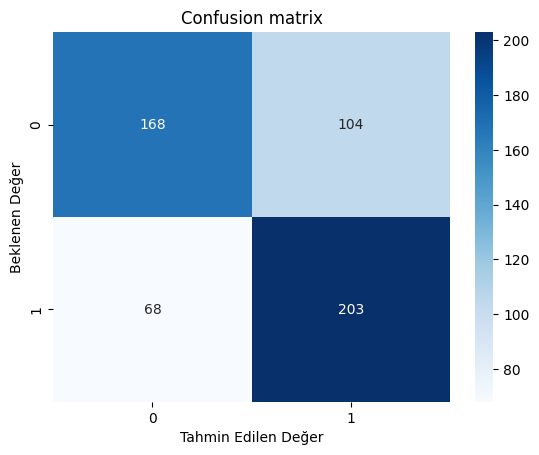

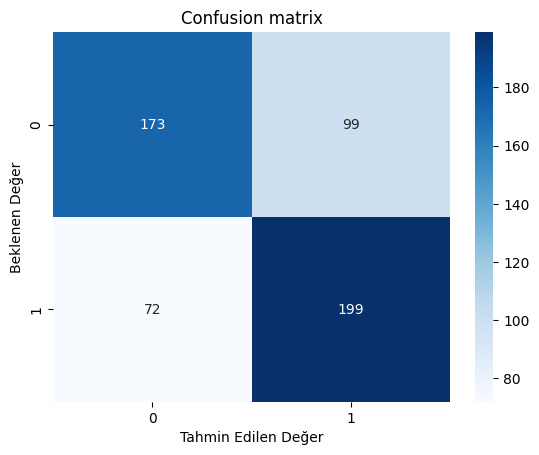

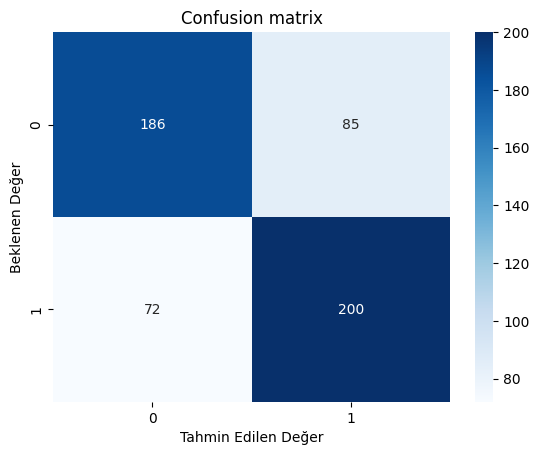

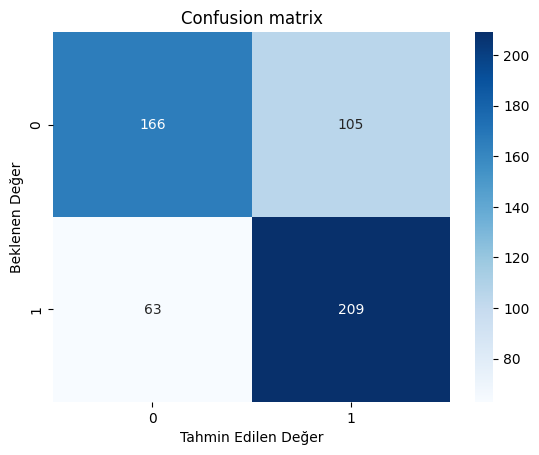

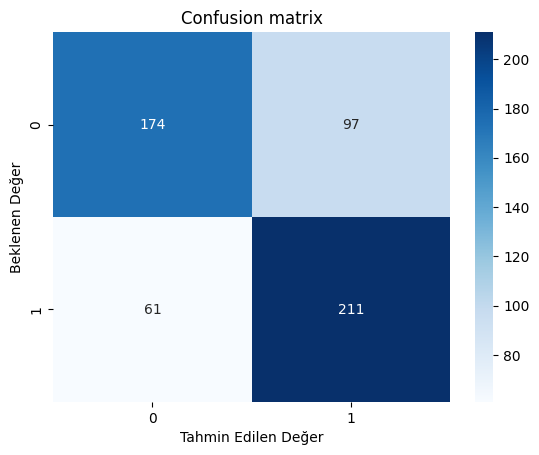

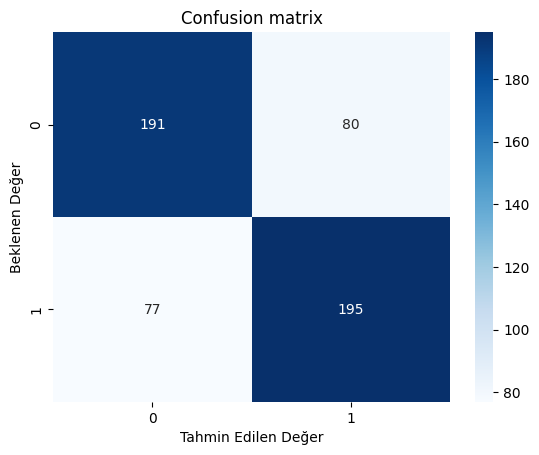

{'fbeta': [0.7192982456140351, 0.7107142857142857, 0.7115044247787611, 0.7162162162162161, 0.7024221453287196, 0.6994727592267136, 0.718132854578097, 0.7133105802047781, 0.7275862068965516, 0.7129798903107862], 'precision': [0.6879194630872483, 0.6885813148788927, 0.6836734693877551, 0.660436137071651, 0.6612377850162866, 0.6677852348993288, 0.7017543859649122, 0.6656050955414012, 0.685064935064935, 0.7090909090909091], 'recall': [0.7536764705882353, 0.7343173431734318, 0.7416974169741697, 0.7822878228782287, 0.7490774907749077, 0.7343173431734318, 0.7352941176470589, 0.7683823529411765, 0.7757352941176471, 0.7169117647058824], 'accuracy': [0.7058823529411765, 0.7016574585635359, 0.6998158379373849, 0.6906077348066298, 0.6832412523020258, 0.6850828729281768, 0.7108655616942909, 0.6906077348066298, 0.7090239410681399, 0.7108655616942909], 'y_test': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

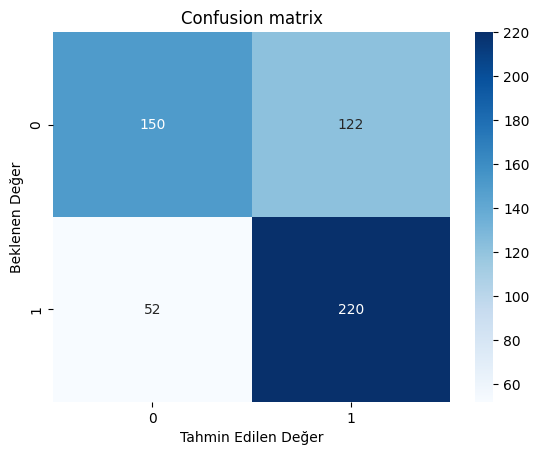

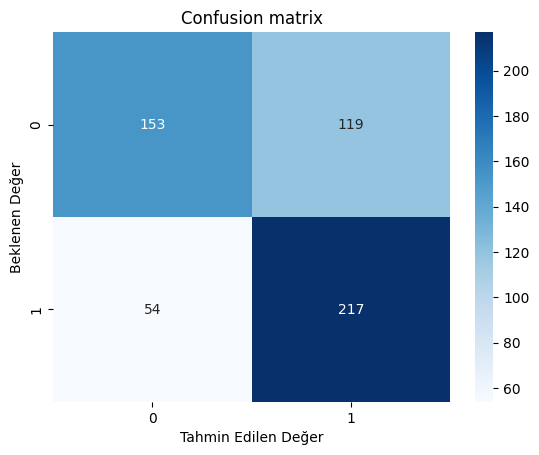

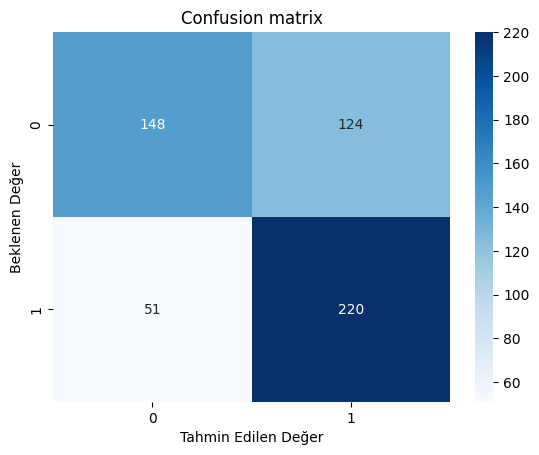

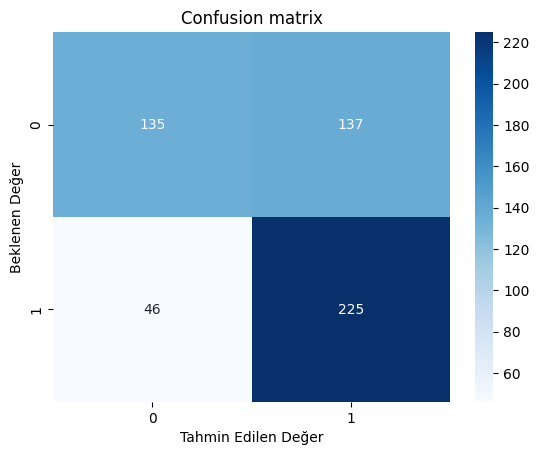

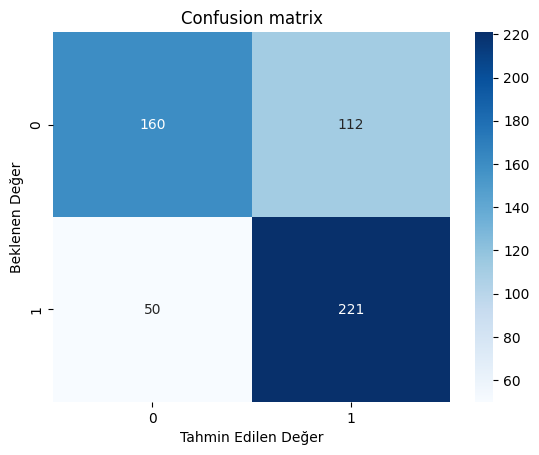

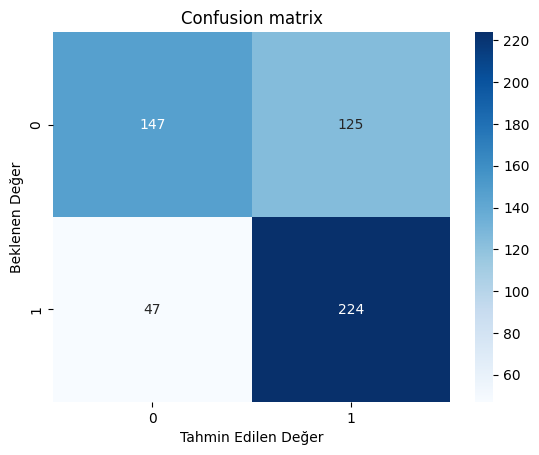

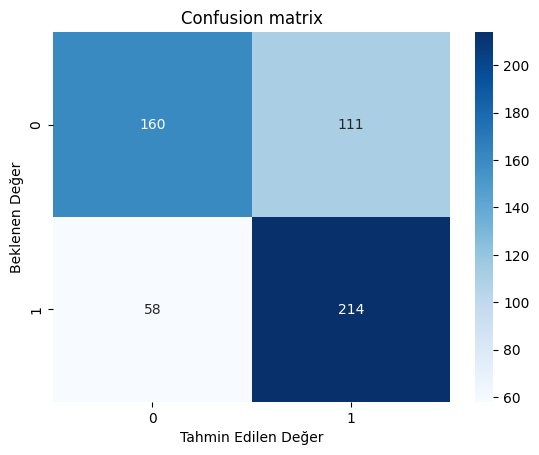

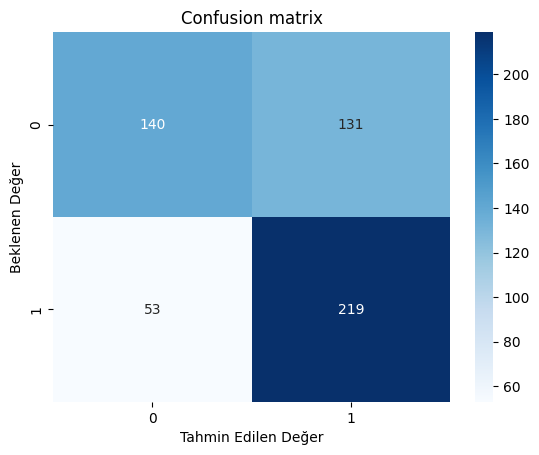

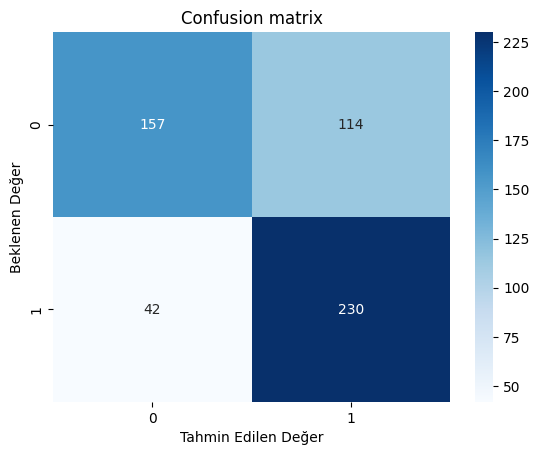

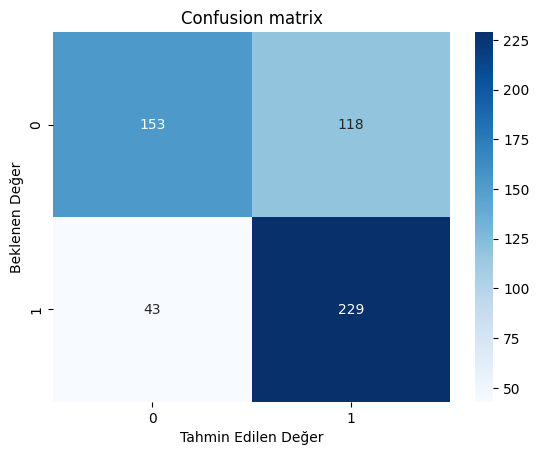

{'fbeta': [0.7166123778501629, 0.71499176276771, 0.7154471544715448, 0.7109004739336493, 0.7317880794701987, 0.7225806451612905, 0.7169179229480738, 0.7041800643086817, 0.7467532467532467, 0.7399030694668821], 'precision': [0.6432748538011696, 0.6458333333333334, 0.6395348837209303, 0.6215469613259669, 0.6636636636636637, 0.6418338108882522, 0.6584615384615384, 0.6257142857142857, 0.6686046511627907, 0.659942363112392], 'recall': [0.8088235294117647, 0.8007380073800738, 0.8118081180811808, 0.8302583025830258, 0.8154981549815498, 0.8265682656826568, 0.7867647058823529, 0.8051470588235294, 0.8455882352941176, 0.8419117647058824], 'accuracy': [0.6801470588235294, 0.6813996316758748, 0.6777163904235728, 0.6629834254143646, 0.7016574585635359, 0.6832412523020258, 0.6887661141804788, 0.6611418047882136, 0.712707182320442, 0.7034990791896869], 'y_test': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

mi
GaussianNB


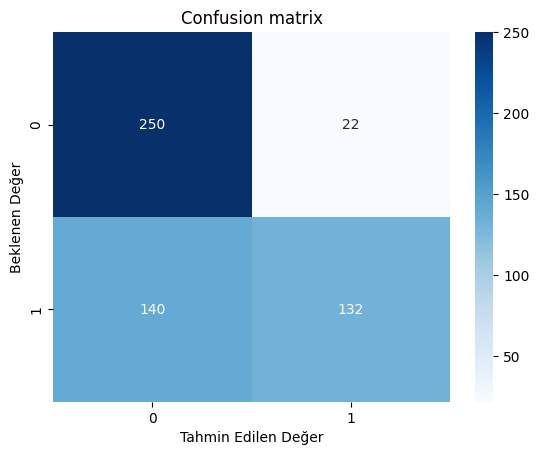

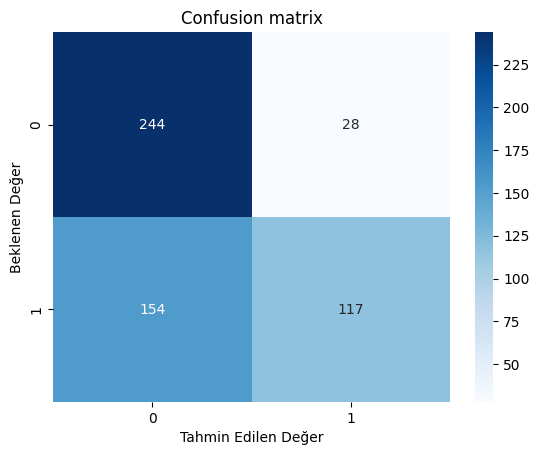

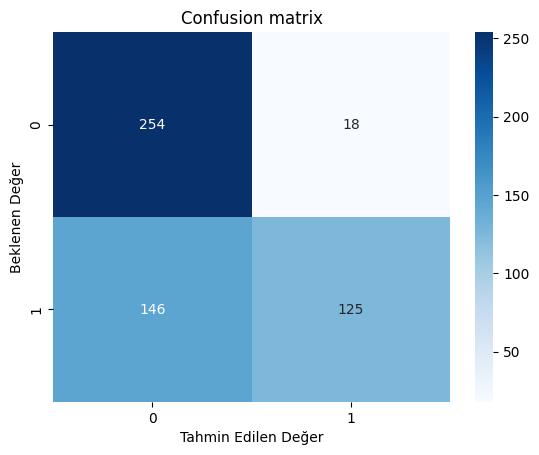

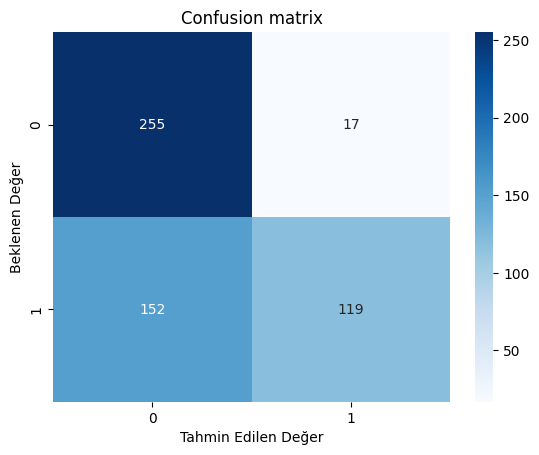

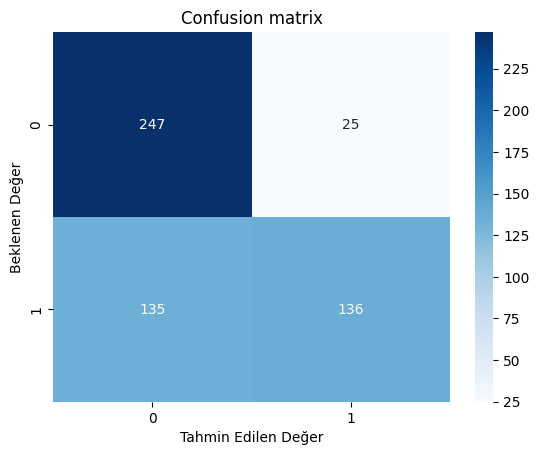

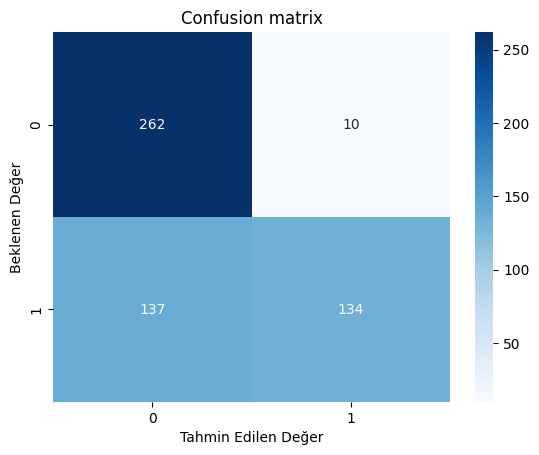

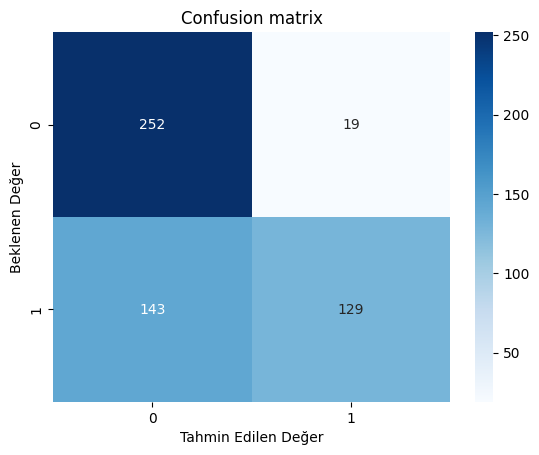

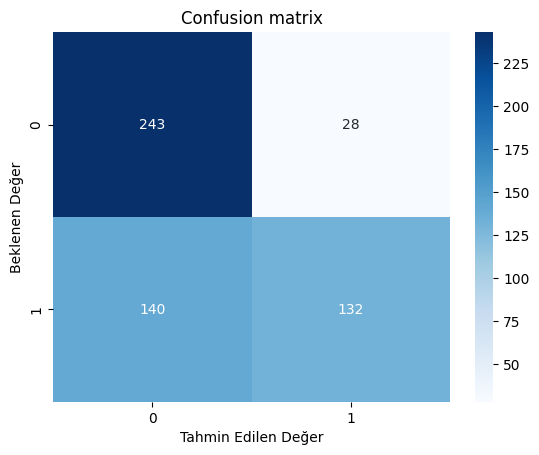

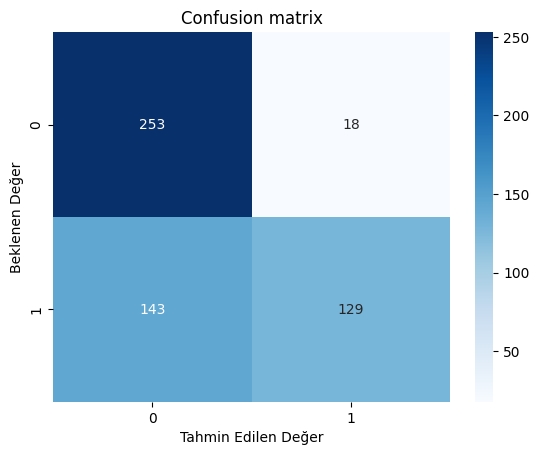

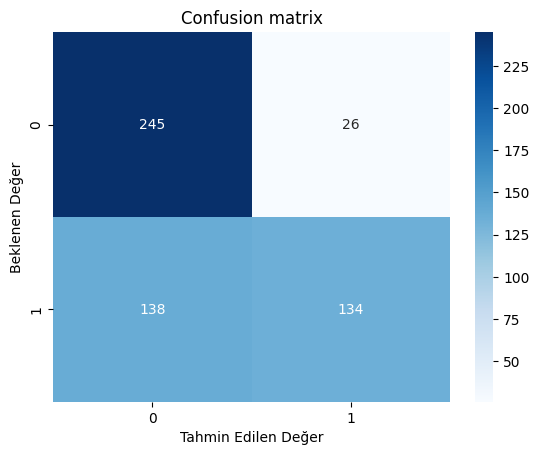

{'fbeta': [0.6197183098591549, 0.5625, 0.6038647342995169, 0.5847665847665847, 0.6296296296296295, 0.6457831325301205, 0.6142857142857142, 0.611111111111111, 0.6157517899761336, 0.6203703703703705], 'precision': [0.8571428571428571, 0.8068965517241379, 0.8741258741258742, 0.875, 0.84472049689441, 0.9305555555555556, 0.8716216216216216, 0.825, 0.8775510204081632, 0.8375], 'recall': [0.4852941176470588, 0.4317343173431734, 0.4612546125461255, 0.43911439114391143, 0.5018450184501845, 0.4944649446494465, 0.4742647058823529, 0.4852941176470588, 0.4742647058823529, 0.49264705882352944], 'accuracy': [0.7022058823529411, 0.6648250460405156, 0.6979742173112339, 0.6887661141804788, 0.7053406998158379, 0.7292817679558011, 0.7016574585635359, 0.6906077348066298, 0.7034990791896869, 0.6979742173112339], 'y_test': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

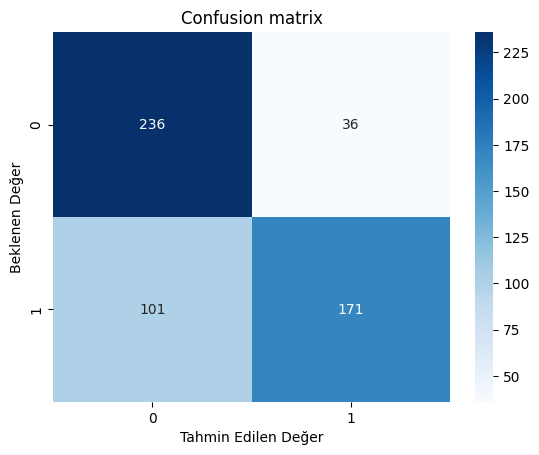

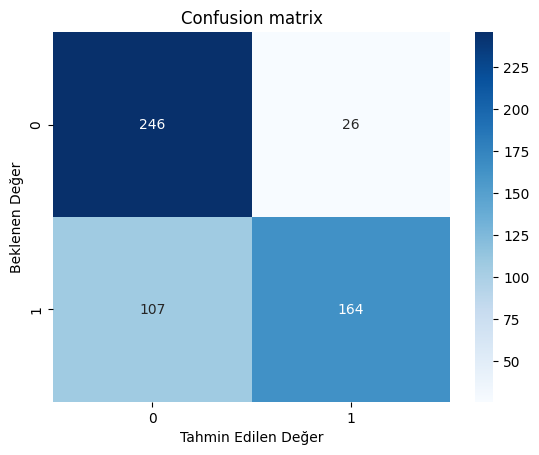

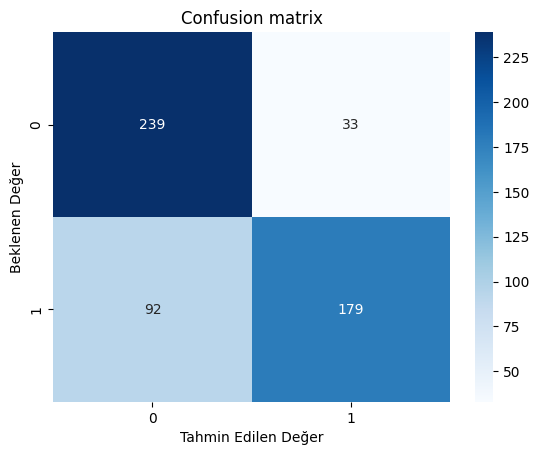

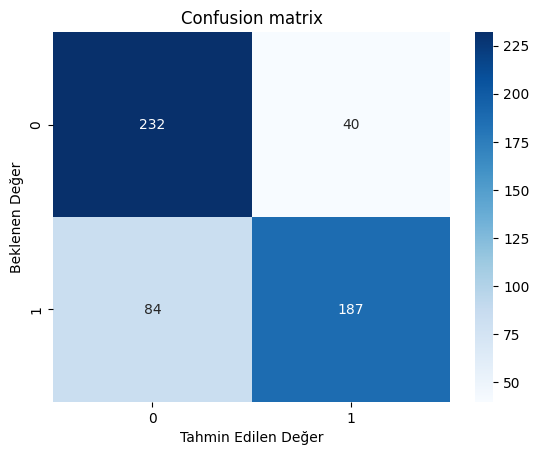

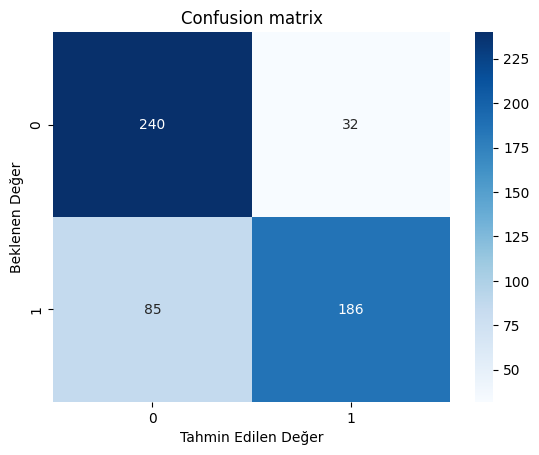

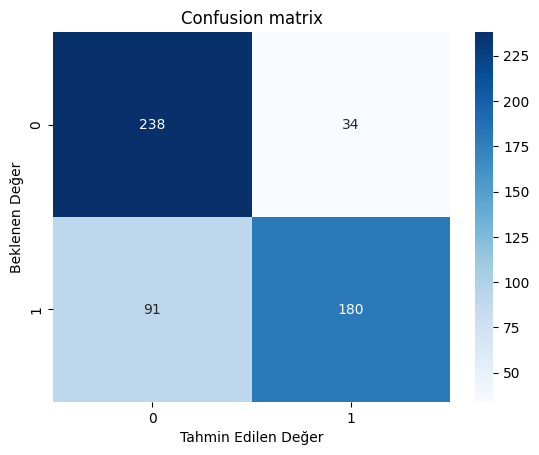

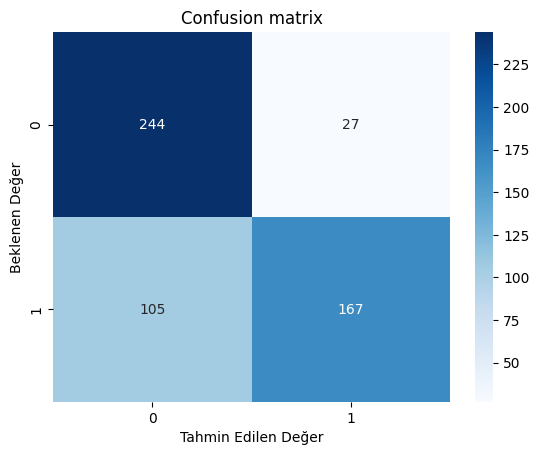

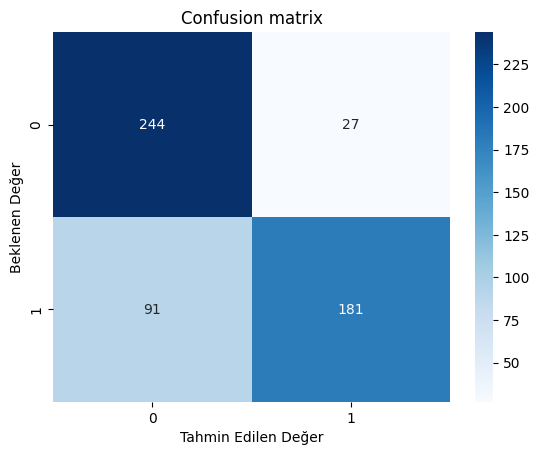

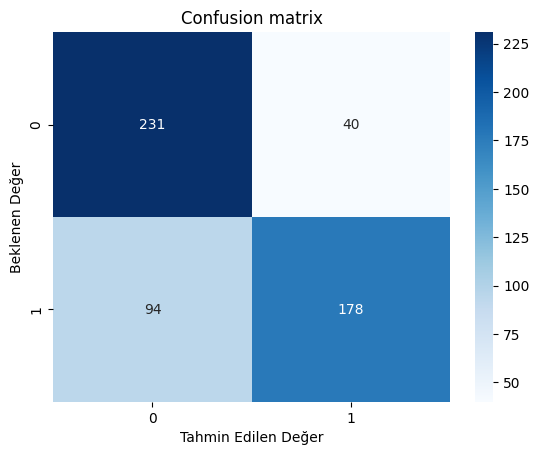

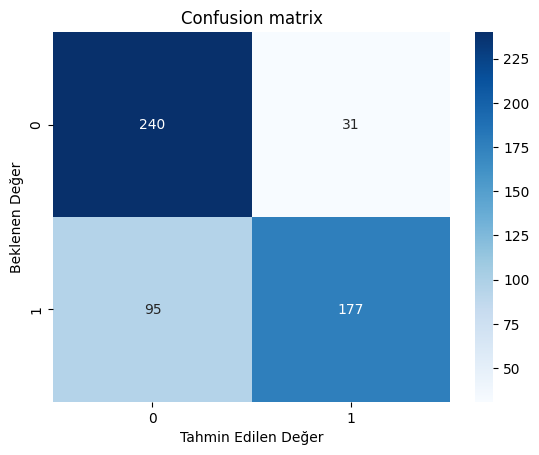

{'fbeta': [0.7139874739039667, 0.7114967462039046, 0.74120082815735, 0.751004016064257, 0.7607361963190185, 0.7422680412371133, 0.7167381974248926, 0.7541666666666668, 0.7265306122448979, 0.7375], 'precision': [0.8260869565217391, 0.8631578947368421, 0.8443396226415094, 0.8237885462555066, 0.8532110091743119, 0.8411214953271028, 0.8608247422680413, 0.8701923076923077, 0.8165137614678899, 0.8509615384615384], 'recall': [0.6286764705882353, 0.6051660516605166, 0.6605166051660517, 0.6900369003690037, 0.6863468634686347, 0.6642066420664207, 0.6139705882352942, 0.6654411764705882, 0.6544117647058824, 0.6507352941176471], 'accuracy': [0.7481617647058824, 0.7550644567219152, 0.7697974217311234, 0.7716390423572744, 0.7845303867403315, 0.7697974217311234, 0.7569060773480663, 0.7826887661141805, 0.7532228360957642, 0.7679558011049724], 'y_test': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     

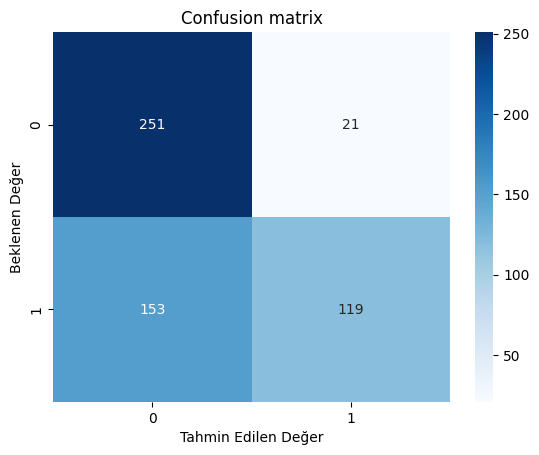

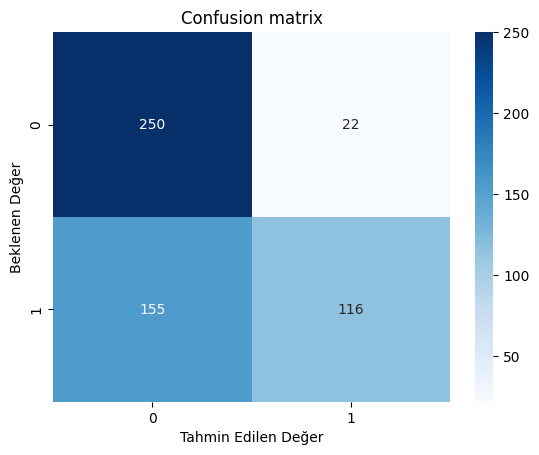

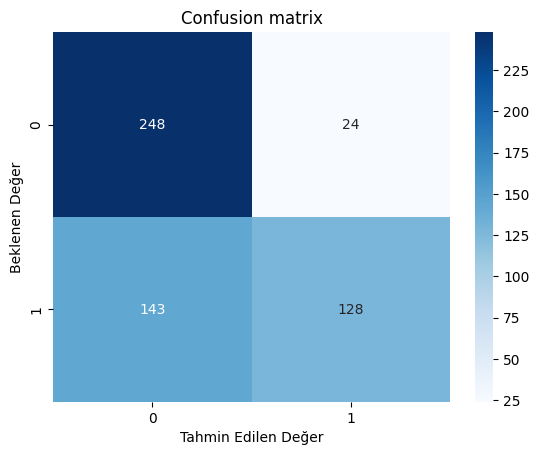

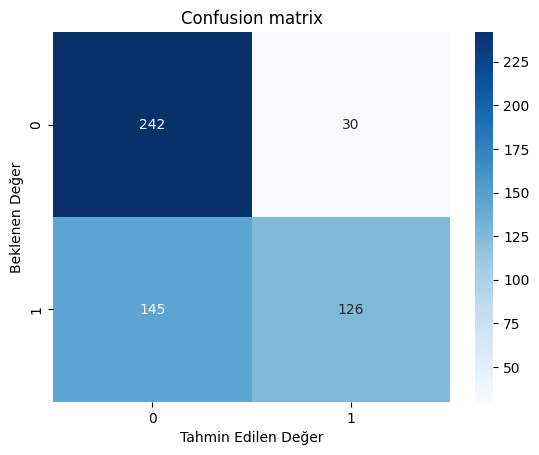

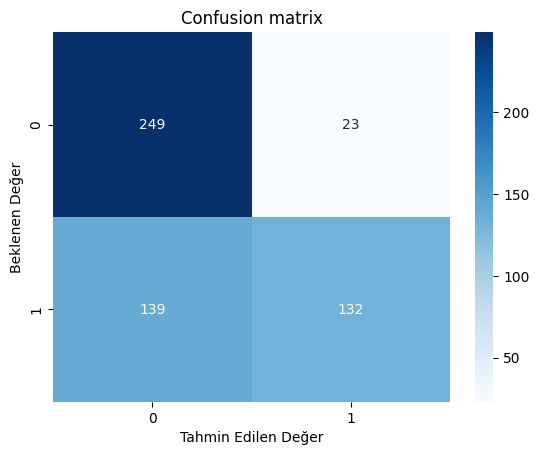

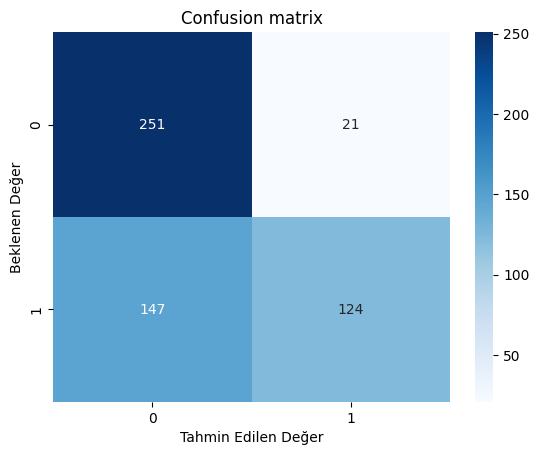

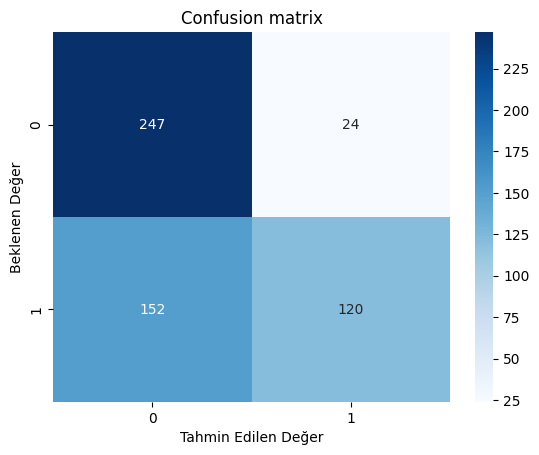

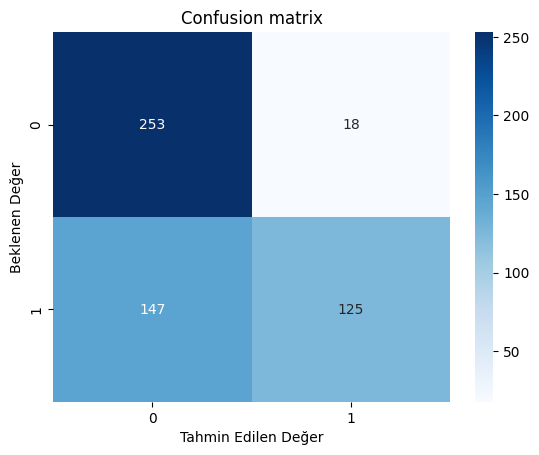

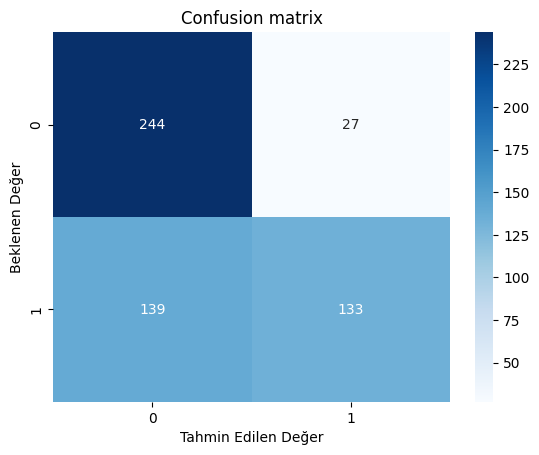

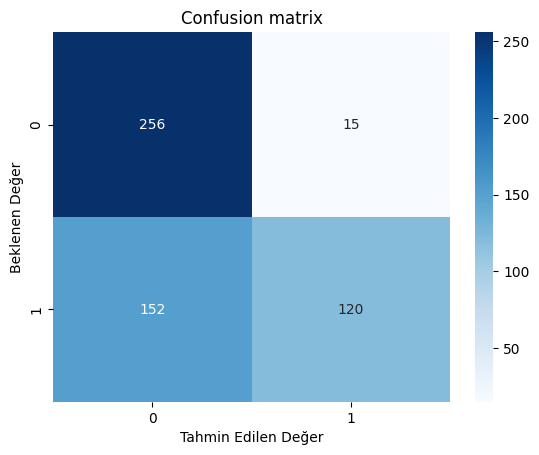

{'fbeta': [0.5776699029126213, 0.5672371638141809, 0.6052009456264775, 0.5901639344262295, 0.6197183098591549, 0.5961538461538461, 0.576923076923077, 0.6024096385542168, 0.6157407407407407, 0.5896805896805896], 'precision': [0.85, 0.8405797101449275, 0.8421052631578947, 0.8076923076923077, 0.8516129032258064, 0.8551724137931035, 0.8333333333333334, 0.8741258741258742, 0.83125, 0.8888888888888888], 'recall': [0.4375, 0.4280442804428044, 0.47232472324723246, 0.46494464944649444, 0.4870848708487085, 0.4575645756457565, 0.4411764705882353, 0.45955882352941174, 0.4889705882352941, 0.4411764705882353], 'accuracy': [0.6801470588235294, 0.6740331491712708, 0.6924493554327809, 0.6777163904235728, 0.7016574585635359, 0.6906077348066298, 0.6758747697974218, 0.6961325966850829, 0.6942909760589319, 0.6924493554327809], 'y_test': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 

In [16]:
weightingTypes = ['idf', 'chi2', 'or','ig','mi']
#weightingTypes = ['ig','mi']
machineLearningTypes = ["GaussianNB", "LogisticRegression", "RandomForestClassifier"]
result_dic={}
for i in weightingTypes:
    word_vectors, file_classes = my_test(i)
    Y=list(file_classes.values())
    X=word_vectors
    Y=(np.array(Y))
    print(i)
    for m in machineLearningTypes:
        print(m)
        machineLearning(m)
        indexformedian=0
        find_median(k_result_dic)
        a=i+m
        print (a)
        
        result_dic[a]=[k_result_dic[score][indexformedian] for score in k_result_dic.keys()]
        k_result_dic={"fbeta" : [], "precision" : [], "recall" : [], "accuracy" : [], "y_test" : [], "y_pred": []}
        print(result_dic)
        
print(result_dic)
    